In [66]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import umap
from sklearn.cluster import AgglomerativeClustering
from collections import Counter
from sklearn import metrics
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import adjusted_rand_score, silhouette_score, mean_squared_error
from models.cluster.HierarchicalModel import HierarchicalModel
import warnings
warnings.filterwarnings("ignore")

In [67]:
X_train = pd.read_csv('data/umist_cropped.csv')

In [68]:
X_train.head(5)

pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  pixel_7  \
0    234.0    234.0    234.0    234.0    234.0    234.0    234.0    234.0   
1    234.0    234.0    234.0    234.0    234.0    234.0    234.0    234.0   
2    234.0    234.0    234.0    234.0    234.0    234.0    234.0    233.0   
3    234.0    234.0    234.0    234.0    233.0    230.0    225.0    109.0   
4    234.0    234.0    234.0    234.0    234.0    234.0    234.0    234.0   

   pixel_8  pixel_9  ...  pixel_10294  pixel_10295  pixel_10296  pixel_10297  \
0    234.0    233.0  ...        195.0        195.0        193.0        192.0   
1    234.0    234.0  ...        192.0        192.0        191.0        186.0   
2    225.0    186.0  ...        192.0        192.0        191.0        185.0   
3     85.0     84.0  ...        180.0        174.0        168.0        164.0   
4    234.0    234.0  ...        192.0        192.0        191.0        190.0   

   pixel_10298  pixel_10299  pixel_10300  pixel_10301  pixel_10302  \
0        192.0        192.0        192.0        191.0        190.0   
1        183.0        179.0        174.0        169.0        165.0   
2        184.0        177.0        170.0        166.0        164.0   
3        157.0        152.0        151.0        148.0        145.0   
4        188.0        184.0        177.0        173.0        168.0   

   pixel_10303  
0        191.0  
1        164.0  
2        163.0  
3        145.0  
4        164.0  

[5 rows x 10304 columns]

In [69]:
X_train.shape

(600, 10304)

In [70]:
X_train = X_train.to_numpy()

In [71]:
# 1. Preprocess the Data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
X_scaled

array([[9.77937596e-01, 9.91074847e-01, 9.91092970e-01, ...,
        8.79185122e-01, 8.73521205e-01, 8.78653648e-01],
       [9.77937596e-01, 9.91074847e-01, 9.91092970e-01, ...,
        7.68438150e-01, 7.47042410e-01, 7.42139003e-01],
       [9.77937596e-01, 9.91074847e-01, 9.91092970e-01, ...,
        7.53336290e-01, 7.41983259e-01, 7.37082905e-01],
       ...,
       [5.48521868e-05, 3.07863526e-04, 5.59110309e-04, ...,
        3.45586075e-01, 3.42310267e-01, 3.42707262e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.60485689e-01, 3.47369419e-01, 3.47763360e-01],
       [2.12060911e-02, 2.42945046e-02, 2.70870474e-02, ...,
        3.13761583e-01, 3.09032464e-01, 3.04843503e-01]])

In [72]:
# 2. Apply PCA to Retain 99.5% Variance
pca = PCA(n_components=0.995)
X_pca = pca.fit_transform(X_scaled)
print(f"Number of components chosen by PCA: {X_pca.shape[1]}")

Number of components chosen by PCA: 422


In [73]:
# 3. Apply UMAP on the PCA-Reduced Data
umap_reducer = umap.UMAP(n_components=X_pca.shape[1], random_state=123)
X_umap = umap_reducer.fit_transform(X_pca)
X_umap

array([[1.625185 , 6.7180524, 7.5421567, ..., 4.934257 , 5.031296 ,
        4.4051433],
       [1.7630944, 6.892849 , 7.658367 , ..., 4.9373317, 5.0322556,
        4.4036617],
       [1.7638205, 6.879012 , 7.697441 , ..., 4.9395256, 5.0323153,
        4.4020066],
       ...,
       [7.196301 , 1.7660995, 4.4750333, ..., 4.9391212, 5.0846515,
        4.4325943],
       [7.319667 , 1.8891847, 4.561959 , ..., 4.941394 , 5.0863023,
        4.4317517],
       [7.307882 , 1.8498778, 4.5346265, ..., 4.9407945, 5.0858197,
        4.4318385]], dtype=float32)

In [74]:
errors = []
for n in range(2, 21):  # Test components from 2 to 20
    # Reduce data
    reducer = umap.UMAP(n_components=n, random_state=123)
    reduced_data = reducer.fit_transform(X_pca)
    
    # Reconstruct data
    reconstructor = umap.UMAP(n_components=X_pca.shape[1], random_state=123)
    reconstructed_data = reconstructor.fit_transform(reduced_data)
    
    # Compute error
    mse = mean_squared_error(X_pca, reconstructed_data)
    errors.append((n, mse))

In [75]:
# Print results
least_error = 100
least_error_component = 0
for n, mse in errors:
    if least_error > mse:
        least_error = mse
        least_error_component = n
    print(f"Components: {n}, Reconstruction Error: {mse}")

Components: 2, Reconstruction Error: 26.43460576362447
Components: 3, Reconstruction Error: 26.42255954208118
Components: 4, Reconstruction Error: 27.28445611755594
Components: 5, Reconstruction Error: 27.49210764487176
Components: 6, Reconstruction Error: 26.45719496358524
Components: 7, Reconstruction Error: 26.9292669246509
Components: 8, Reconstruction Error: 26.999075382817953
Components: 9, Reconstruction Error: 26.482084812633765
Components: 10, Reconstruction Error: 26.489877601290416
Components: 11, Reconstruction Error: 27.099061374403444
Components: 12, Reconstruction Error: 27.595090204969736
Components: 13, Reconstruction Error: 26.489629696212116
Components: 14, Reconstruction Error: 27.553555718230086
Components: 15, Reconstruction Error: 26.68886679100065
Components: 16, Reconstruction Error: 27.07979003564126
Components: 17, Reconstruction Error: 26.418059643103785
Components: 18, Reconstruction Error: 26.46511646714902
Components: 19, Reconstruction Error: 26.42300866

In [76]:
print(f"The least error Components: {least_error_component}")

The least error Components: 20


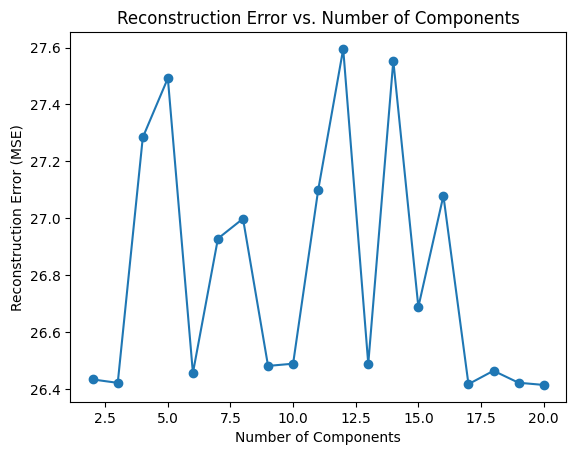

In [77]:
# Extract values for plotting
components = [n for n, _ in errors]
mse_values = [mse for _, mse in errors]

# Plot the reconstruction error
plt.plot(components, mse_values, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error (MSE)')
plt.title('Reconstruction Error vs. Number of Components')
plt.show()

In [78]:
# Apply final the best number of component for UMAP on the PCA-Reduced Data
umap_reducer = umap.UMAP(n_components=least_error_component, random_state=123)
X_umap = umap_reducer.fit_transform(X_pca)
X_umap

array([[1.4466158, 3.5150616, 6.4430714, ..., 5.6610217, 5.496702 ,
        5.557734 ],
       [1.4276587, 3.2845798, 6.4509163, ..., 5.6368513, 5.4707003,
        5.556171 ],
       [1.4632136, 3.3099868, 6.44413  , ..., 5.640732 , 5.4752913,
        5.5627704],
       ...,
       [7.749273 , 7.7618184, 4.7924647, ..., 4.6363463, 5.2449946,
        6.374291 ],
       [7.8389626, 7.660611 , 4.832197 , ..., 4.6059833, 5.2453527,
        6.38243  ],
       [7.845767 , 7.6428456, 4.844336 , ..., 4.601168 , 5.2473187,
        6.382236 ]], dtype=float32)

In [79]:
# Initialize Agglomerative Clustering
expected_cluster = 20
agg_cluster = AgglomerativeClustering(n_clusters=expected_cluster, metric='euclidean', linkage='ward')
# Fit the model and predict cluster labels
cluster_labels = agg_cluster.fit_predict(X_umap)
agg_cluster_labels = cluster_labels

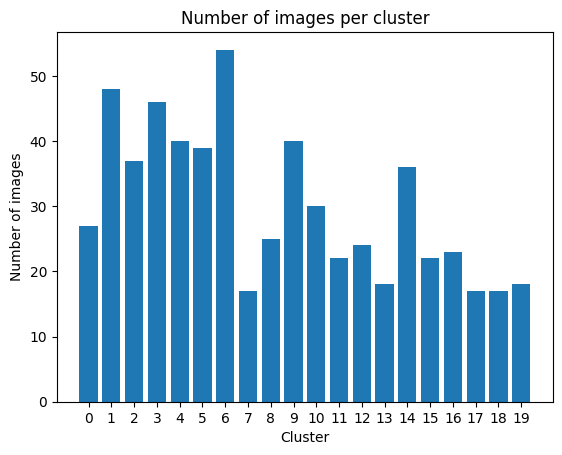

In [80]:
plt.bar(range(expected_cluster), np.bincount(cluster_labels))
plt.xlabel('Cluster')
plt.ylabel('Number of images')
plt.title('Number of images per cluster')
plt.xticks(range(expected_cluster))
plt.show()

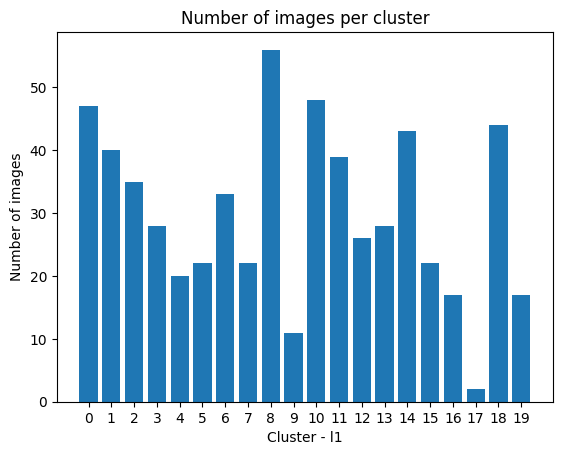

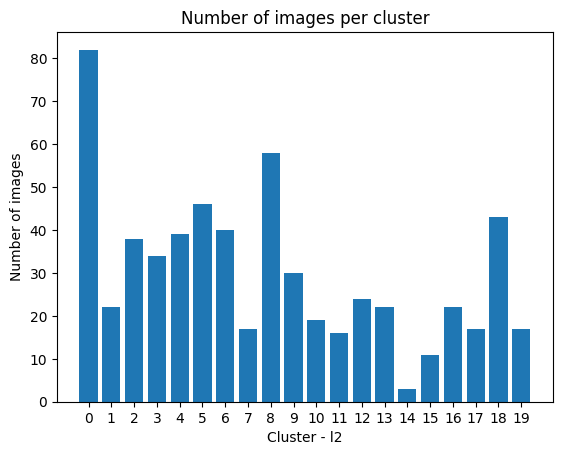

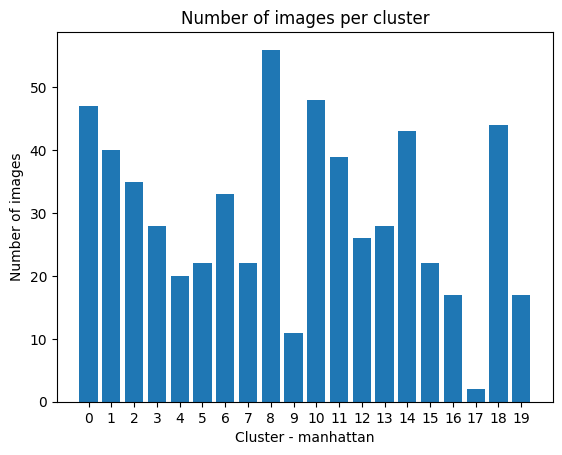

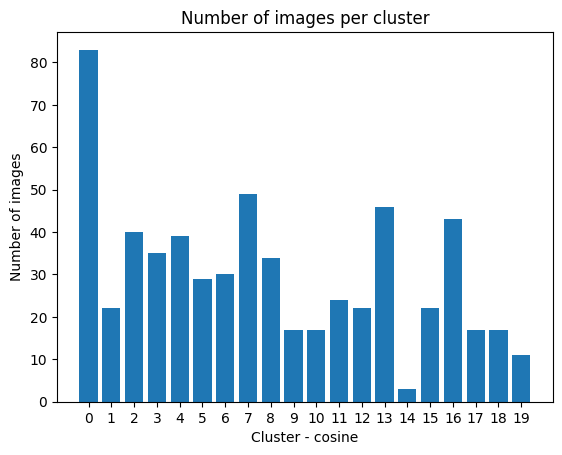

In [81]:
metrics = ['l1', 'l2', 'manhattan', 'cosine']
expected_cluster = 20

for met in metrics:
    agg_cluster = AgglomerativeClustering(n_clusters=expected_cluster, metric=met, linkage='average')
    
    # Fit the model and predict cluster labels
    cluster_labels = agg_cluster.fit_predict(X_umap)

    plt.bar(range(expected_cluster), np.bincount(cluster_labels))
    plt.xlabel(f'Cluster - {met}')
    plt.ylabel('Number of images')
    plt.title('Number of images per cluster')
    plt.xticks(range(expected_cluster))
    plt.show() 

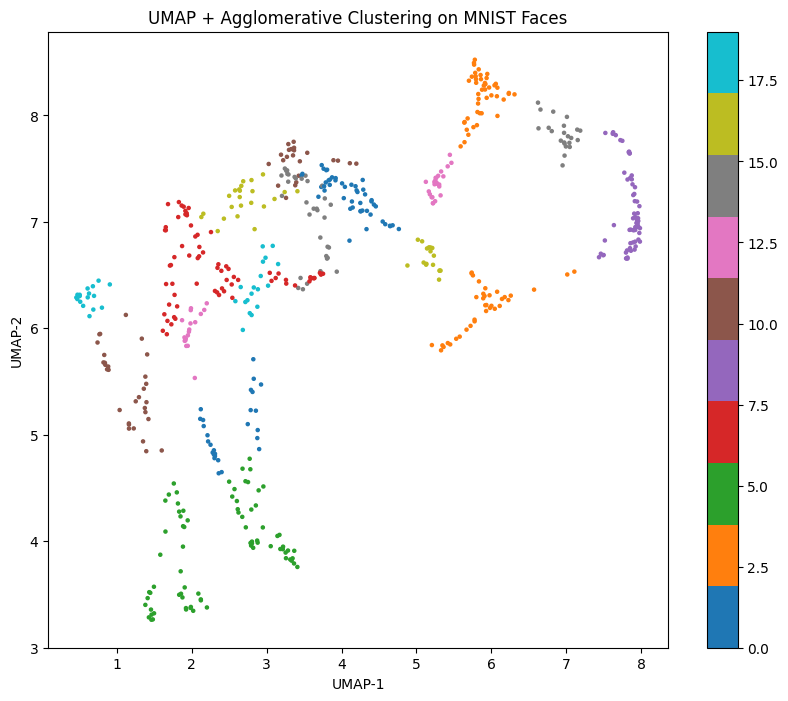

In [82]:
plt.figure(figsize=(10, 8))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=agg_cluster_labels, cmap='tab10', s=5)
plt.colorbar()
plt.title("UMAP + Agglomerative Clustering on MNIST Faces")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

In [83]:
# Measure the quality of clustering (higher is better for silhouette score)
silhouette = silhouette_score(X_umap, agg_cluster_labels)
print(f"Silhouette Score: {silhouette:.2f}")

Silhouette Score: 0.47


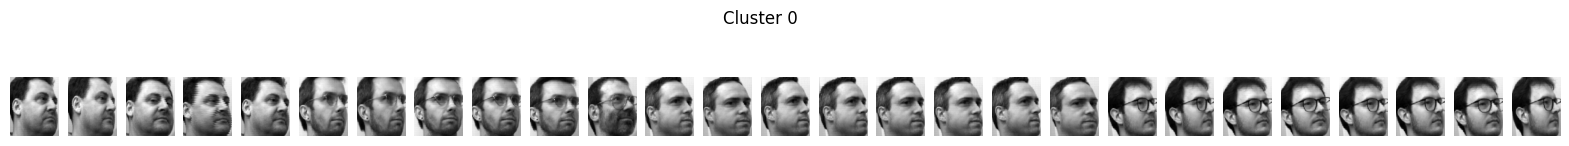

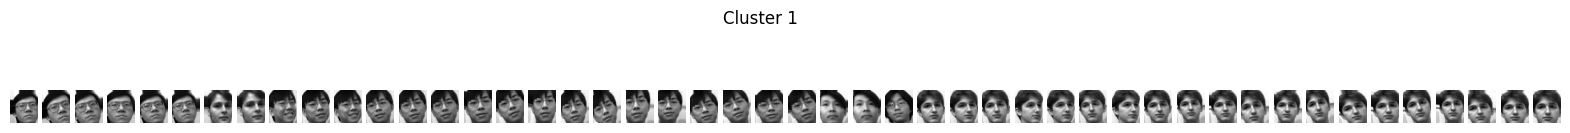

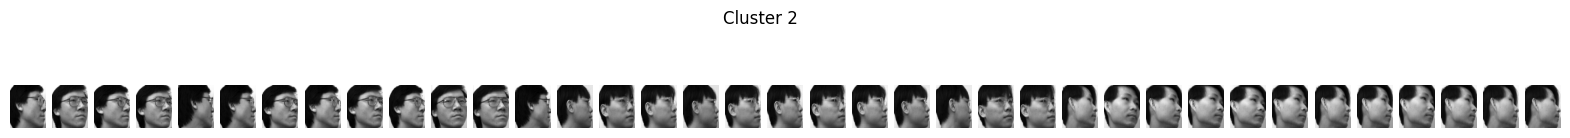

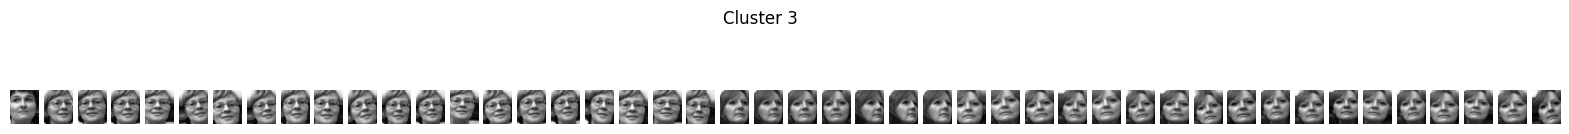

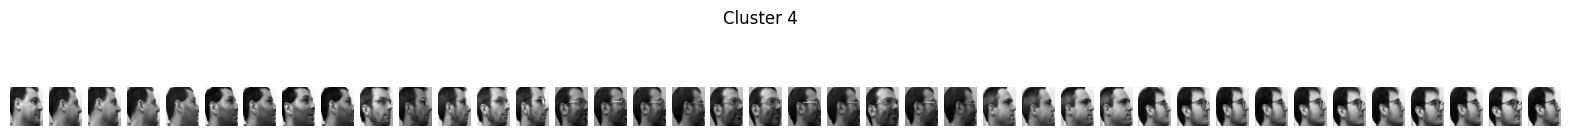

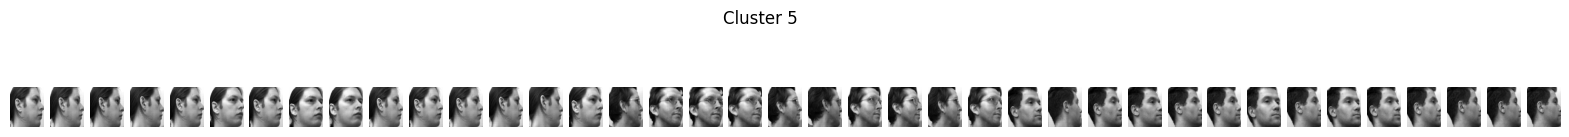

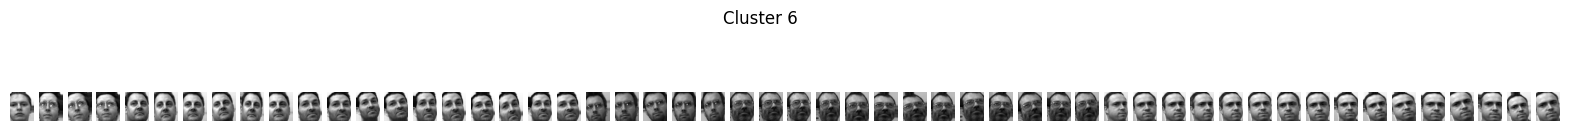

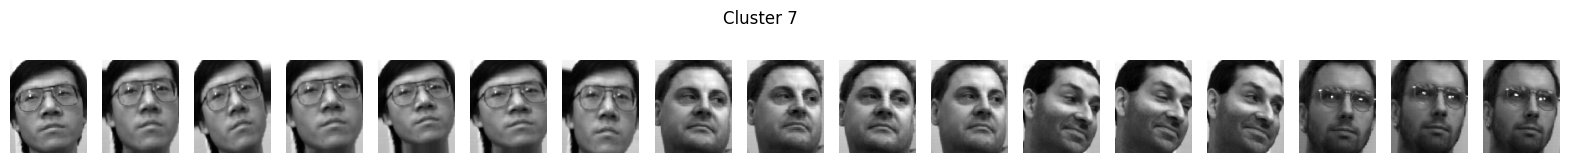

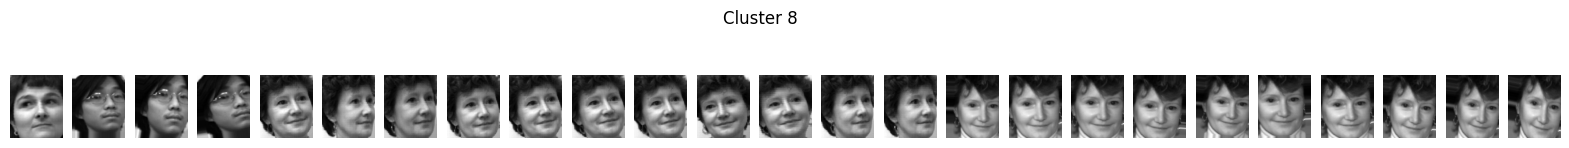

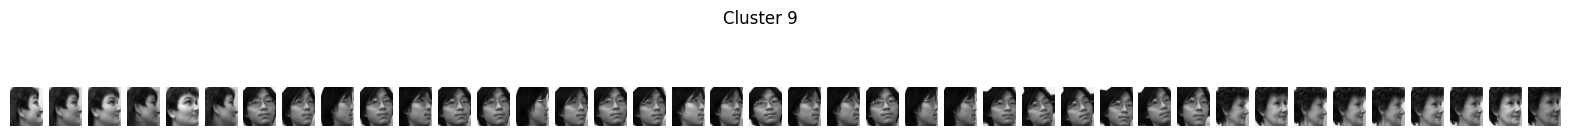

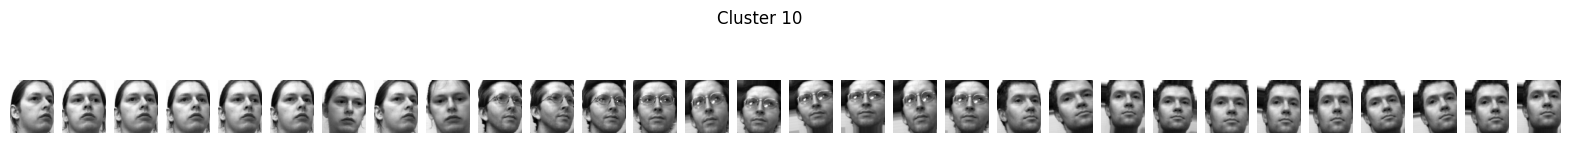

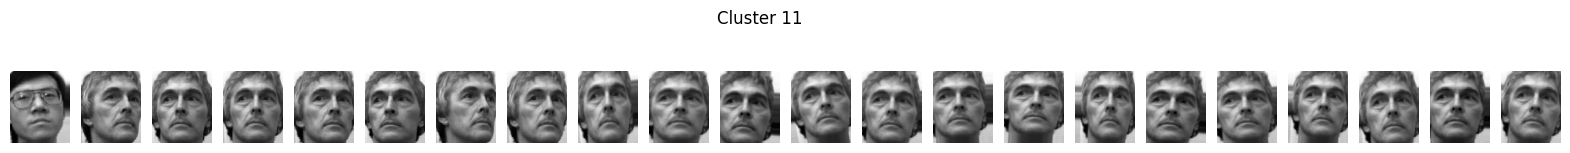

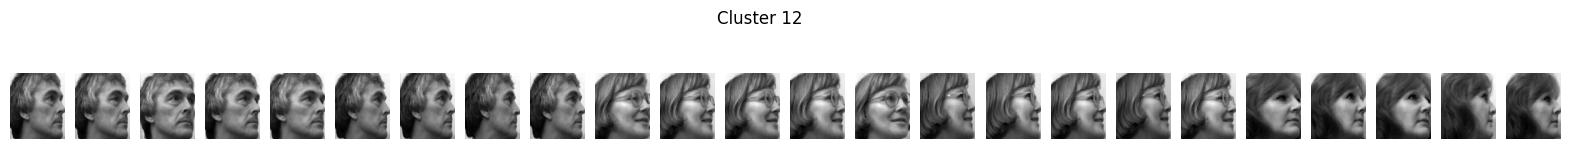

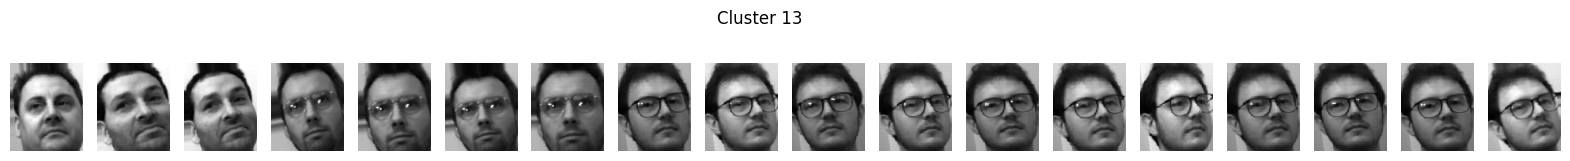

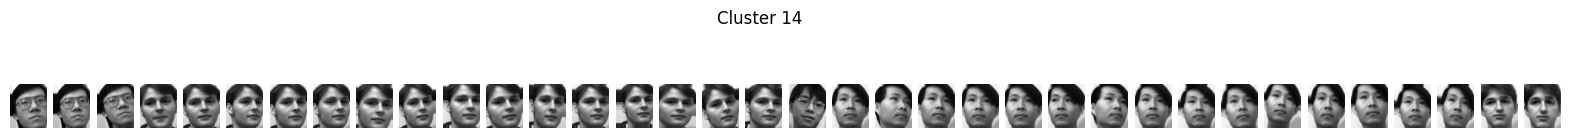

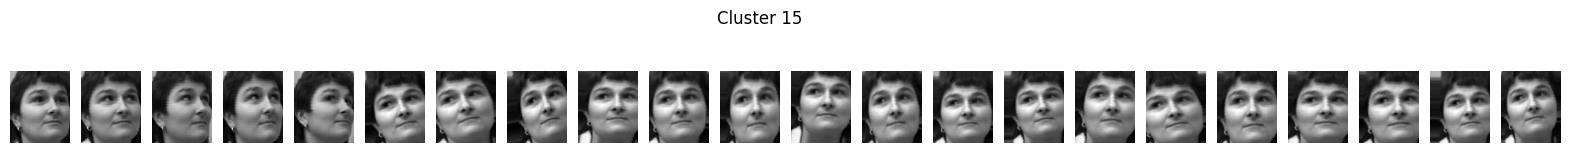

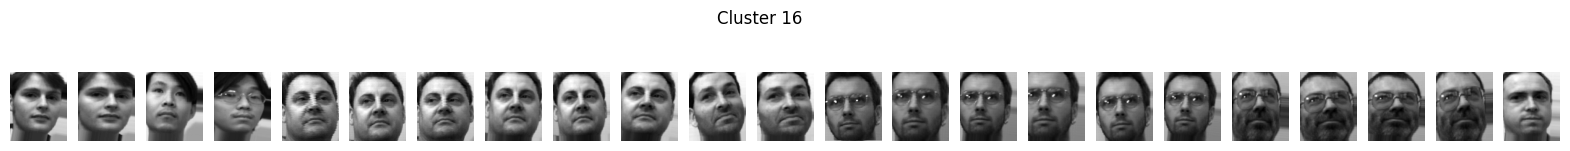

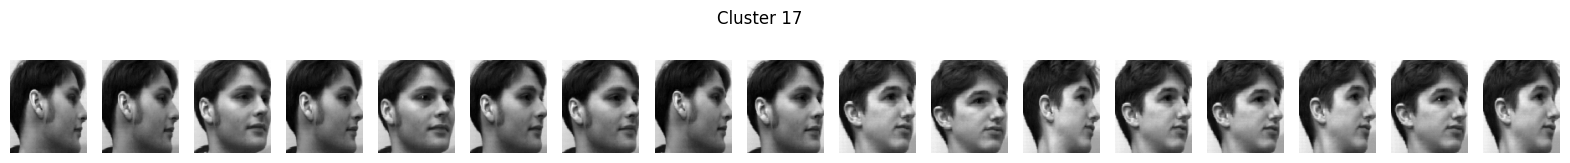

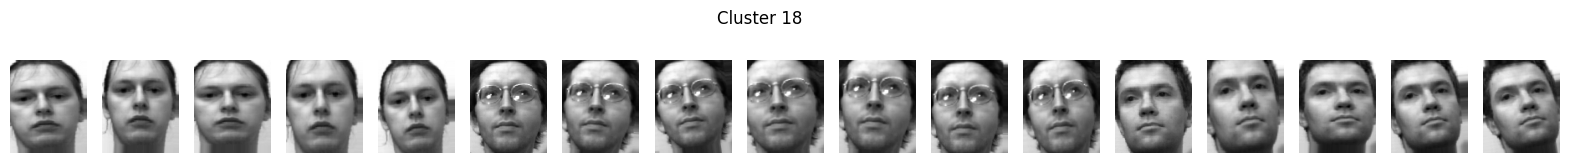

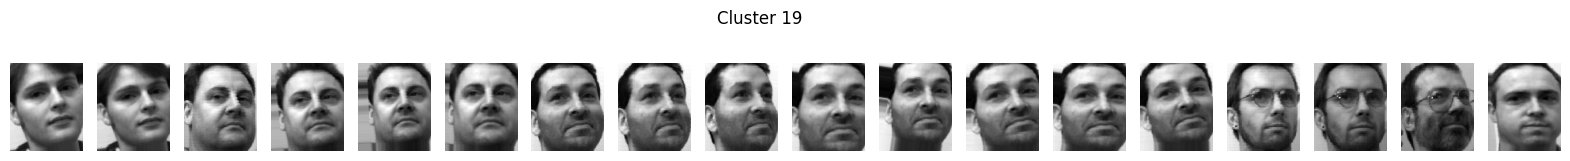

In [84]:
def plot_result(cluster_labels, cluster_num):
    for cluster_id in range(cluster_num+1):
        # Get the indices of images in the current cluster
        cluster_indices = np.where(cluster_labels == cluster_id)[0]
        
        # Determine the number of images to plot
        num_images = len(cluster_indices)
        
        if num_images > 0:
            fig, axes = plt.subplots(1, num_images, figsize=(20, 2))
            
            # Handle the case where there is only one image
            if num_images == 1:
                axes = [axes]  # Convert single axis to a list for consistency
            
            for i in range(num_images):
                # Get the image index
                image_index = cluster_indices[i]
                
                # Get the image data
                image_data = X_train[image_index]
                
                # Reshape the image data
                image_data = image_data.reshape(112, 92)
                
                # Plot the image
                axes[i].imshow(image_data, cmap='gray')
                axes[i].axis('off')
            
            plt.suptitle(f"Cluster {cluster_id}")
            plt.show()
plot_result(agg_cluster_labels, expected_cluster)

Average linkage and euclidean metric: 

Number of clusters: 20
Silhouette Score: 0.4643442928791046


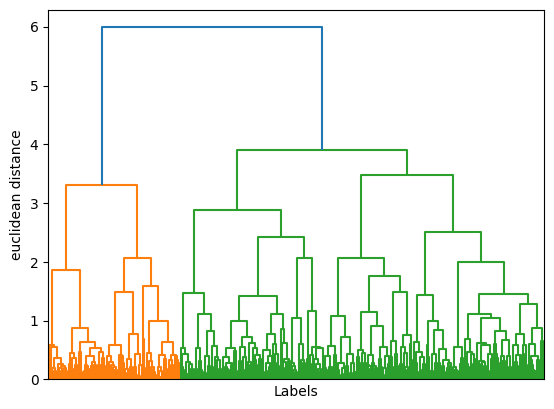

Average linkage and minkowski metric: 

Number of clusters: 20
Silhouette Score: 0.4809251936158309


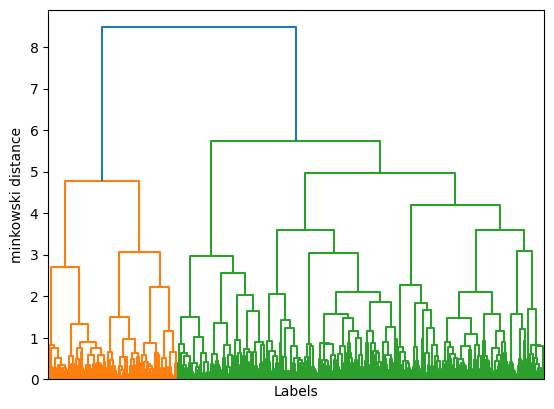

Average linkage and cosine metric: 

Number of clusters: 20
Silhouette Score: 0.6240605711936951


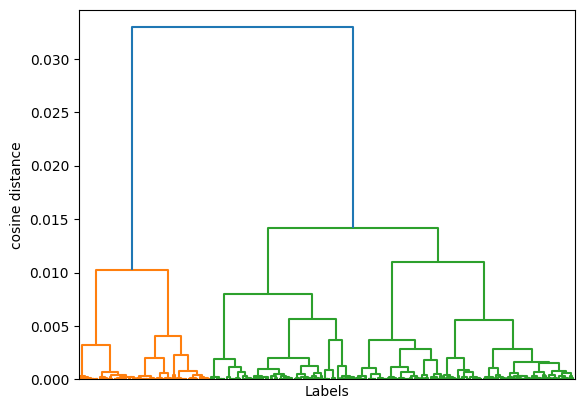

Average linkage and cityblock metric: 

Number of clusters: 20
Silhouette Score: 0.46575736679405166


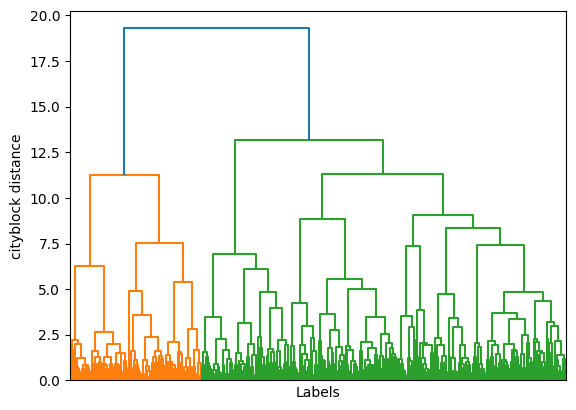

In [85]:
metrics_list = ['euclidean', 'minkowski', 'cosine', 'cityblock']       
                
results = {}
square_distances_matrix = []
clusters_res = []

for m in metrics_list:
    print(f'Average linkage and {m} metric: \n')
    
    if m == 'minkowski':
        Y = pdist(X_umap, metric=m, p=1.5)
    else:
        Y = pdist(X_umap, metric=m)
        
    Z = linkage(Y, method='average')
    clusters = fcluster(Z, 20, criterion='maxclust')
    dendrogram(Z, no_labels= True)
    # Check the number of clusters
    num_clusters = len(set(clusters))
    clusters_res.append(clusters)
    print(f'Number of clusters: {num_clusters}')
    silhouette = silhouette_score(X_umap, clusters, metric=m)
    print(f'Silhouette Score: {silhouette}')
    plt.xlabel("Labels")
    plt.ylabel(f'{m} distance')
    plt.show()

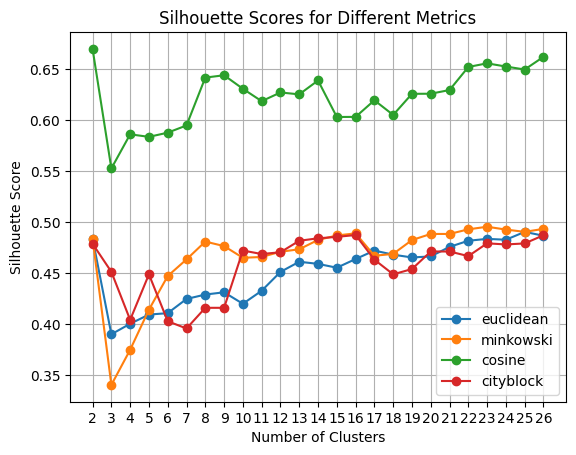

In [86]:
max_clusters = 26  # Maximum number of clusters to test
for metric in metrics_list:
    silhouette_scores = []
    
    # Iterate through the possible number of clusters
    for n_clusters in range(2, max_clusters + 1):  # Start from 2 clusters
        # Compute pairwise distances
        if metric == 'minkowski':
            Y = pdist(X_umap, metric=metric, p=1.5)
        else:
            Y = pdist(X_umap, metric=metric)
        
        if metric in ['euclidean']:
            Z = linkage(Y, method='ward')
        else:
            Z = linkage(Y, method='centroid')

        # Create flat clusters
        clusters = fcluster(Z, n_clusters, criterion='maxclust')

        # Check the number of clusters formed
        num_clusters_formed = len(set(clusters))
        
        # Ensure that the number of clusters is valid
        if num_clusters_formed > 1:
            # Calculate silhouette score
            silhouette = silhouette_score(X_umap, clusters, metric=metric)
            silhouette_scores.append(silhouette)
        else:
            silhouette_scores.append(-1)  # Append a negative score or None if not valid

    # Store results for the current metric
    results[metric] = silhouette_scores

    # Plotting
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o', label=metric)

# Plotting
plt.title("Silhouette Scores for Different Metrics")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.xticks(range(2, max_clusters + 1))
plt.legend()
plt.grid()
plt.show()

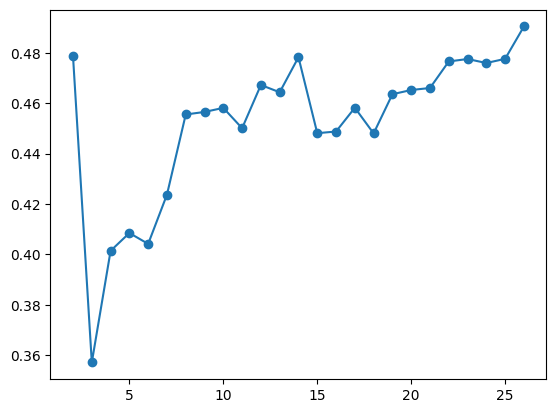

In [87]:
silhouette_scores = []
best_cluster_num = 1
best_score = 0

for n_clusters in range(2, max_clusters + 1):  # Start from 2 clusters
    Y = pdist(X_umap, metric='cosine')
    Z = linkage(Y, method='centroid')
    clusters = fcluster(Z, n_clusters, criterion='maxclust')
    num_clusters_formed = len(set(clusters))
    if num_clusters_formed > 1:
        silhouette = silhouette_score(X_umap, clusters, metric=metric)
        silhouette_scores.append(silhouette)
        if silhouette > best_score:
            best_score = silhouette
            best_cluster_num = num_clusters_formed
    else:
        silhouette_scores.append(-1)  # Append a negative score or None if not valid
# Plotting
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o', label=metric)
plt.show()

In [88]:
print(f'The best cluster number: {best_cluster_num} with score {best_score}')

The best cluster number: 26 with score 0.4904489472209843


In [89]:
original_data = pd.read_csv("data/umist_with_original_face_id.csv")

In [90]:
original_labels = original_data['label']
original_labels = original_labels.to_numpy()

Result for metric = Cosine and linkage = Centroid

Cluster labels for each image: Counter({10: 49, 2: 46, 6: 45, 16: 39, 24: 30, 21: 29, 25: 29, 19: 28, 17: 28, 1: 24, 26: 24, 9: 22, 3: 22, 11: 21, 4: 20, 13: 19, 20: 18, 15: 18, 23: 18, 7: 17, 12: 12, 8: 12, 22: 12, 18: 11, 14: 4, 5: 3})


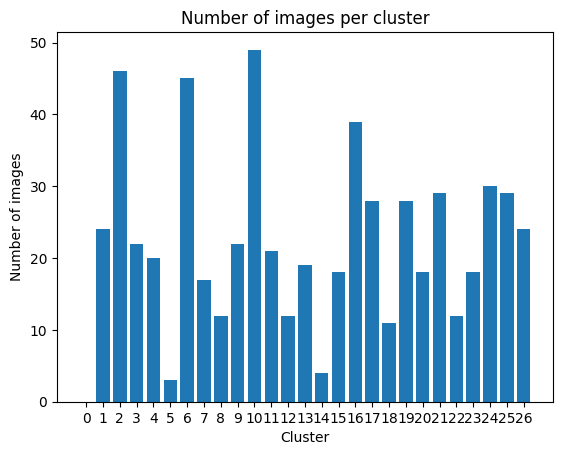

In [91]:
model = HierarchicalModel(best_cluster_num, 'centroid', 'cosine')
cosine_cluster_labels = model.fit_predict(X_umap)
print("Cluster labels for each image:", Counter(cosine_cluster_labels))

plt.bar(range(best_cluster_num +1), np.bincount(cosine_cluster_labels))
plt.xlabel('Cluster')
plt.ylabel('Number of images')
plt.title('Number of images per cluster')
plt.xticks(range(best_cluster_num+1))
plt.show()


Clusters with majority percentage > 50% (sorted by cluster ID):
Cluster 2: Majority label 8 with 25 images (54.3%)
Cluster 3: Majority label 6 with 22 images (100.0%)
Cluster 4: Majority label 19 with 19 images (95.0%)
Cluster 5: Majority label 3 with 3 images (100.0%)
Cluster 6: Majority label 11 with 28 images (62.2%)
Cluster 7: Majority label 5 with 9 images (52.9%)
Cluster 8: Majority label 10 with 12 images (100.0%)
Cluster 9: Majority label 9 with 12 images (54.5%)
Cluster 11: Majority label 10 with 13 images (61.9%)
Cluster 12: Majority label 5 with 9 images (75.0%)
Cluster 14: Majority label 4 with 4 images (100.0%)
Cluster 15: Majority label 4 with 17 images (94.4%)
Cluster 22: Majority label 17 with 12 images (100.0%)
Cluster 23: Majority label 18 with 11 images (61.1%)

Clusters with majority percentage <= 50% (sorted by true label):
Cluster 16: Majority label 0 with 15 images (38.5%)
Cluster 20: Majority label 0 with 8 images (44.4%)
Cluster 21: Majority label 1 with 13 im

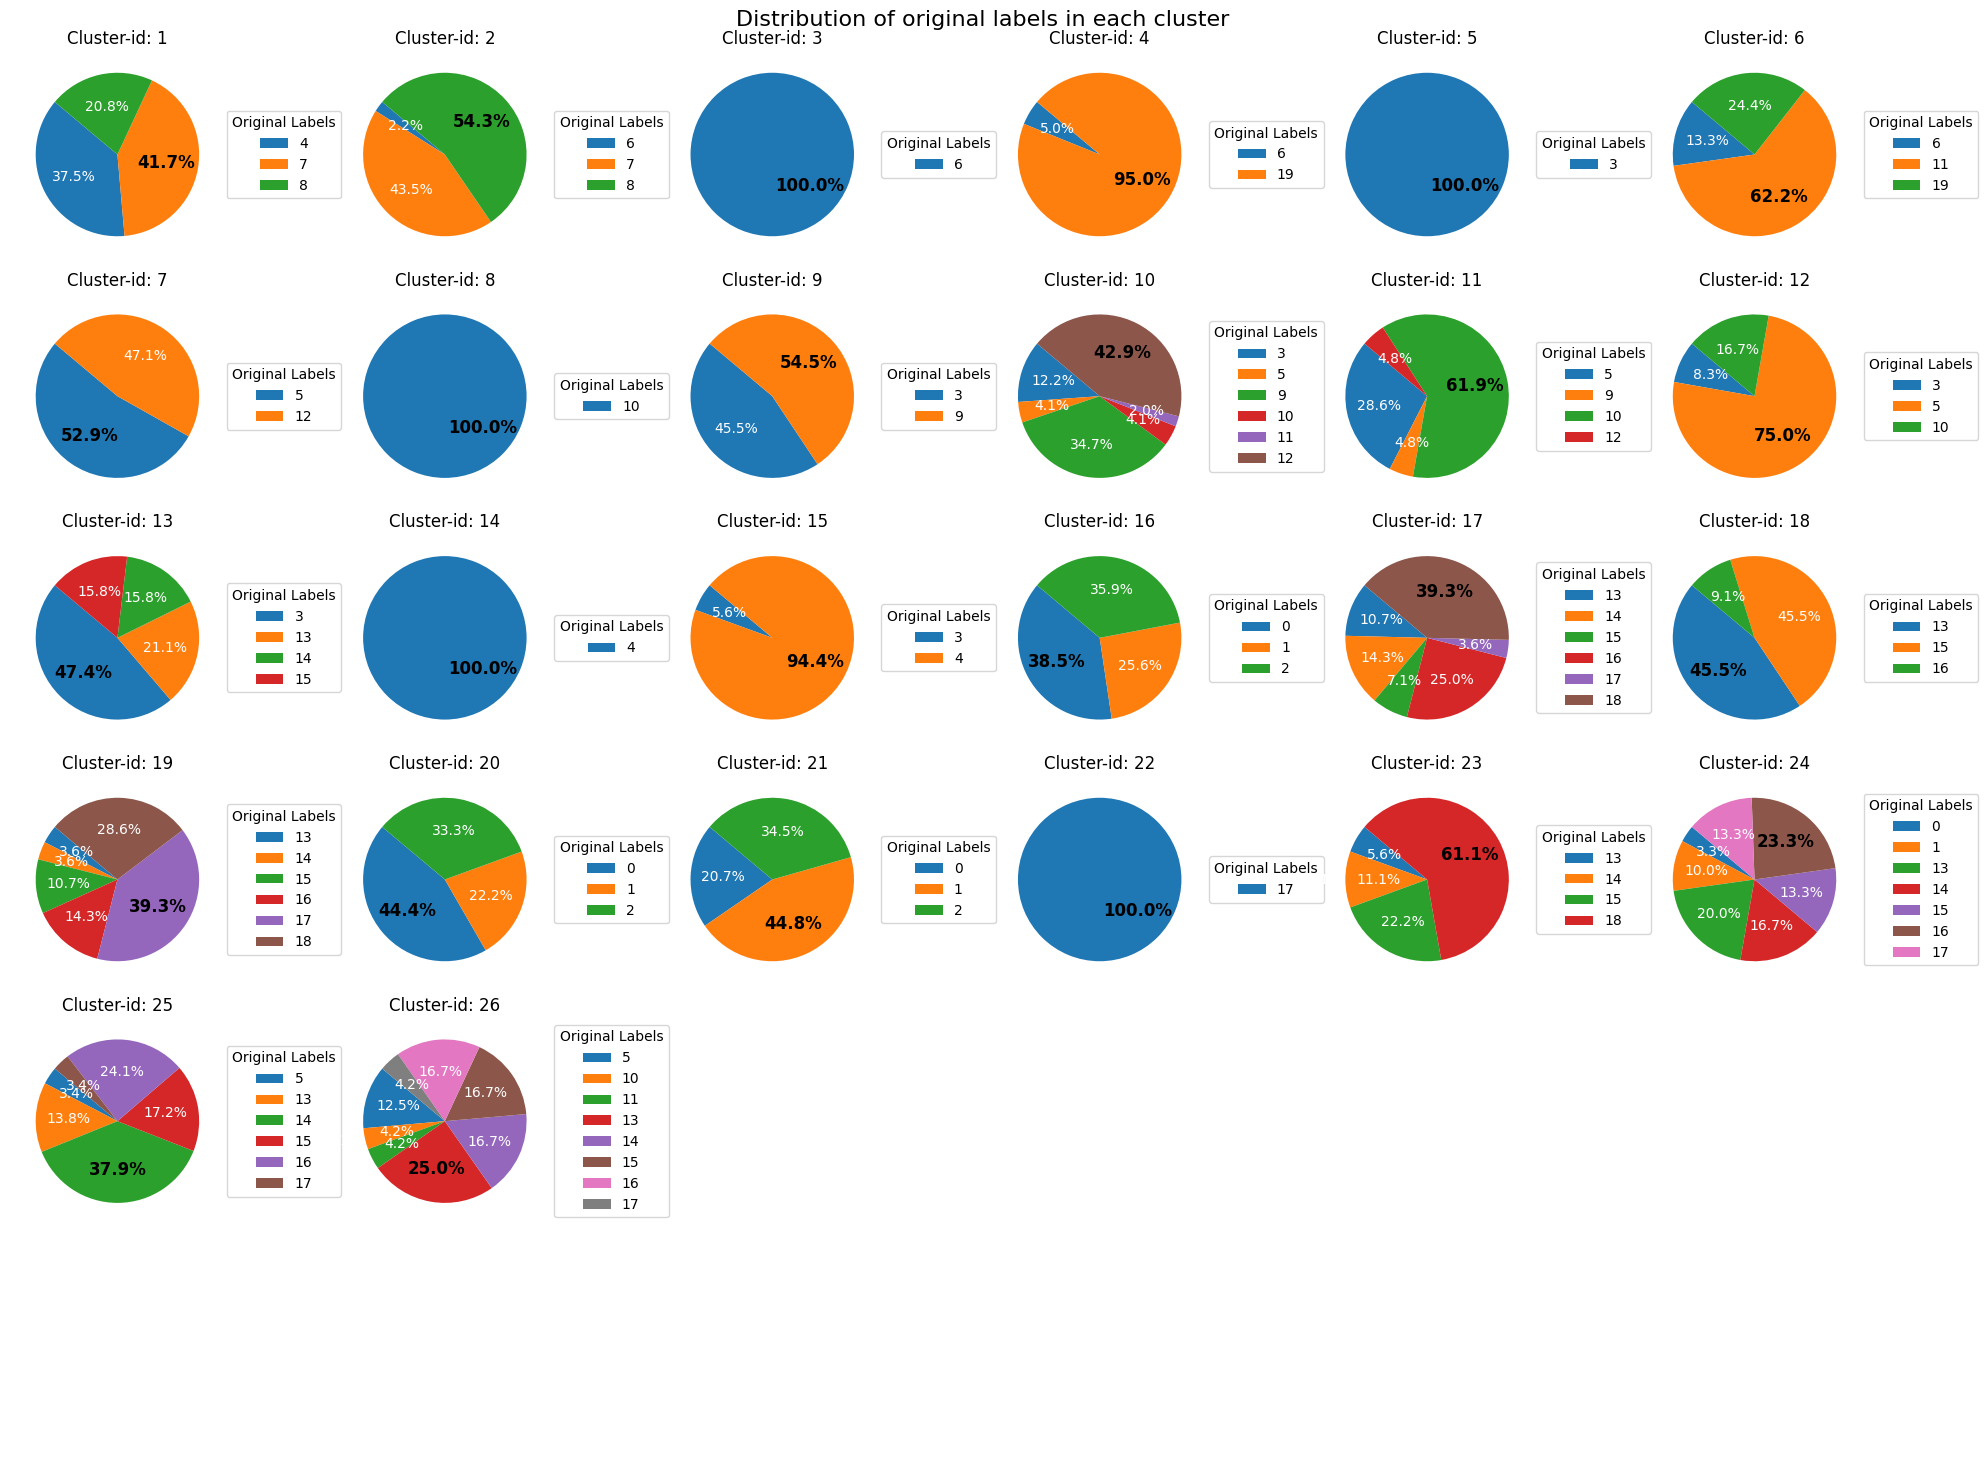

In [92]:
import math
def plot_cluster_distribution_with_majority(original_labels, clustered_labels):
    # Get unique clusters
    unique_clustered_labels = np.unique(clustered_labels)
    
    # Store the results for further sorting
    majority_labels = []

    # Calculate grid dimensions
    num_clusters = len(unique_clustered_labels)
    grid_size = math.ceil(math.sqrt(num_clusters))  # Determine size of the grid (square root for square layout)

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(20, 15), subplot_kw=dict(aspect="equal"))
    axes = axes.flatten()

    for i, cluster in enumerate(unique_clustered_labels):
        # Filter data for the current cluster
        cluster_data_indices = np.where(clustered_labels == cluster)[0]
        cluster_original_labels = [original_labels[idx] for idx in cluster_data_indices]

        # Count occurrences of original labels in the current cluster
        cluster_original_labels_count = Counter(cluster_original_labels)
        labels = list(cluster_original_labels_count.keys())
        counts = list(cluster_original_labels_count.values())

        # Plot pie chart
        wedges, texts, autotexts = axes[i].pie(
            counts,
            labels=labels,
            autopct=lambda pct: f"{pct:.1f}%" if pct > 0 else '',
            textprops=dict(color="w"),
            startangle=140
        )

        axes[i].legend(wedges, labels, title='Original Labels', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))

        # Highlight the largest percentage
        largest_pct_idx = np.argmax(counts)
        autotexts[largest_pct_idx].set_color('black')
        autotexts[largest_pct_idx].set_fontsize(12)
        autotexts[largest_pct_idx].set_fontweight('bold')

        axes[i].set_title(f'Cluster-id: {cluster}')

        # Find majority label for the cluster
        majority_label, count = cluster_original_labels_count.most_common(1)[0]
        total = sum(cluster_original_labels_count.values())
        percentage = (count / total) * 100

        # Append the cluster, majority label, count, and percentage to the list
        majority_labels.append((cluster, majority_label, count, percentage))

    # Turn off unused subplots
    for j in range(num_clusters, len(axes)):
        axes[j].axis('off')

    # Separate clusters based on the percentage
    high_majority = [x for x in majority_labels if x[3] > 50]
    low_majority = [x for x in majority_labels if x[3] <= 50]

    # Sort high_majority by cluster ID
    high_majority.sort(key=lambda x: x[0])

    # Sort low_majority by majority label (true label)
    low_majority.sort(key=lambda x: x[1])

    # Print sorted results
    print("\nClusters with majority percentage > 50% (sorted by cluster ID):")
    for cluster, majority_label, count, percentage in high_majority:
        print(f"Cluster {cluster}: Majority label {majority_label} with {count} images ({percentage:.1f}%)")

    print("\nClusters with majority percentage <= 50% (sorted by true label):")
    for cluster, majority_label, count, percentage in low_majority:
        print(f"Cluster {cluster}: Majority label {majority_label} with {count} images ({percentage:.1f}%)")

    plt.suptitle('Distribution of original labels in each cluster', fontsize=16)
    plt.tight_layout()
    plt.show()

plot_cluster_distribution_with_majority(original_labels, cosine_cluster_labels)

Result for metric = Euclidean and linkage = Ward

Cluster labels for each image: Counter({2: 46, 3: 40, 15: 40, 21: 35, 19: 30, 10: 29, 8: 25, 5: 25, 17: 24, 1: 24, 23: 23, 11: 22, 14: 22, 4: 22, 20: 19, 9: 19, 22: 18, 24: 18, 18: 17, 12: 17, 6: 17, 25: 16, 16: 15, 13: 14, 7: 12, 26: 11})


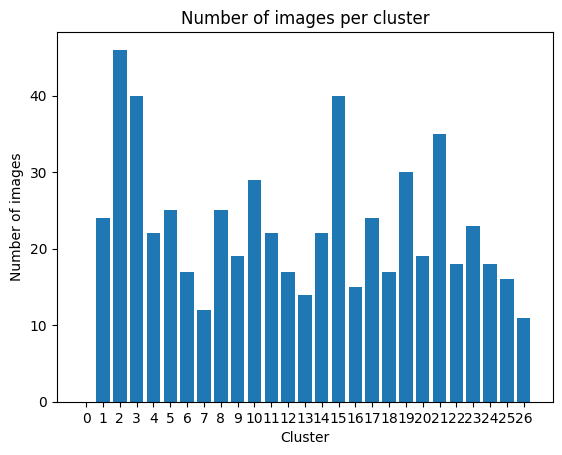


Clusters with majority percentage > 50% (sorted by cluster ID):
Cluster 2: Majority label 8 with 25 images (54.3%)
Cluster 3: Majority label 11 with 25 images (62.5%)
Cluster 4: Majority label 6 with 22 images (100.0%)
Cluster 5: Majority label 19 with 21 images (84.0%)
Cluster 6: Majority label 5 with 9 images (52.9%)
Cluster 7: Majority label 10 with 12 images (100.0%)
Cluster 8: Majority label 3 with 13 images (52.0%)
Cluster 11: Majority label 4 with 21 images (95.5%)
Cluster 13: Majority label 5 with 9 images (64.3%)
Cluster 14: Majority label 10 with 13 images (59.1%)
Cluster 24: Majority label 18 with 11 images (61.1%)

Clusters with majority percentage <= 50% (sorted by true label):
Cluster 17: Majority label 0 with 11 images (45.8%)
Cluster 16: Majority label 1 with 6 images (40.0%)
Cluster 18: Majority label 1 with 7 images (41.2%)
Cluster 19: Majority label 2 with 11 images (36.7%)
Cluster 12: Majority label 3 with 7 images (41.2%)
Cluster 1: Majority label 7 with 10 images

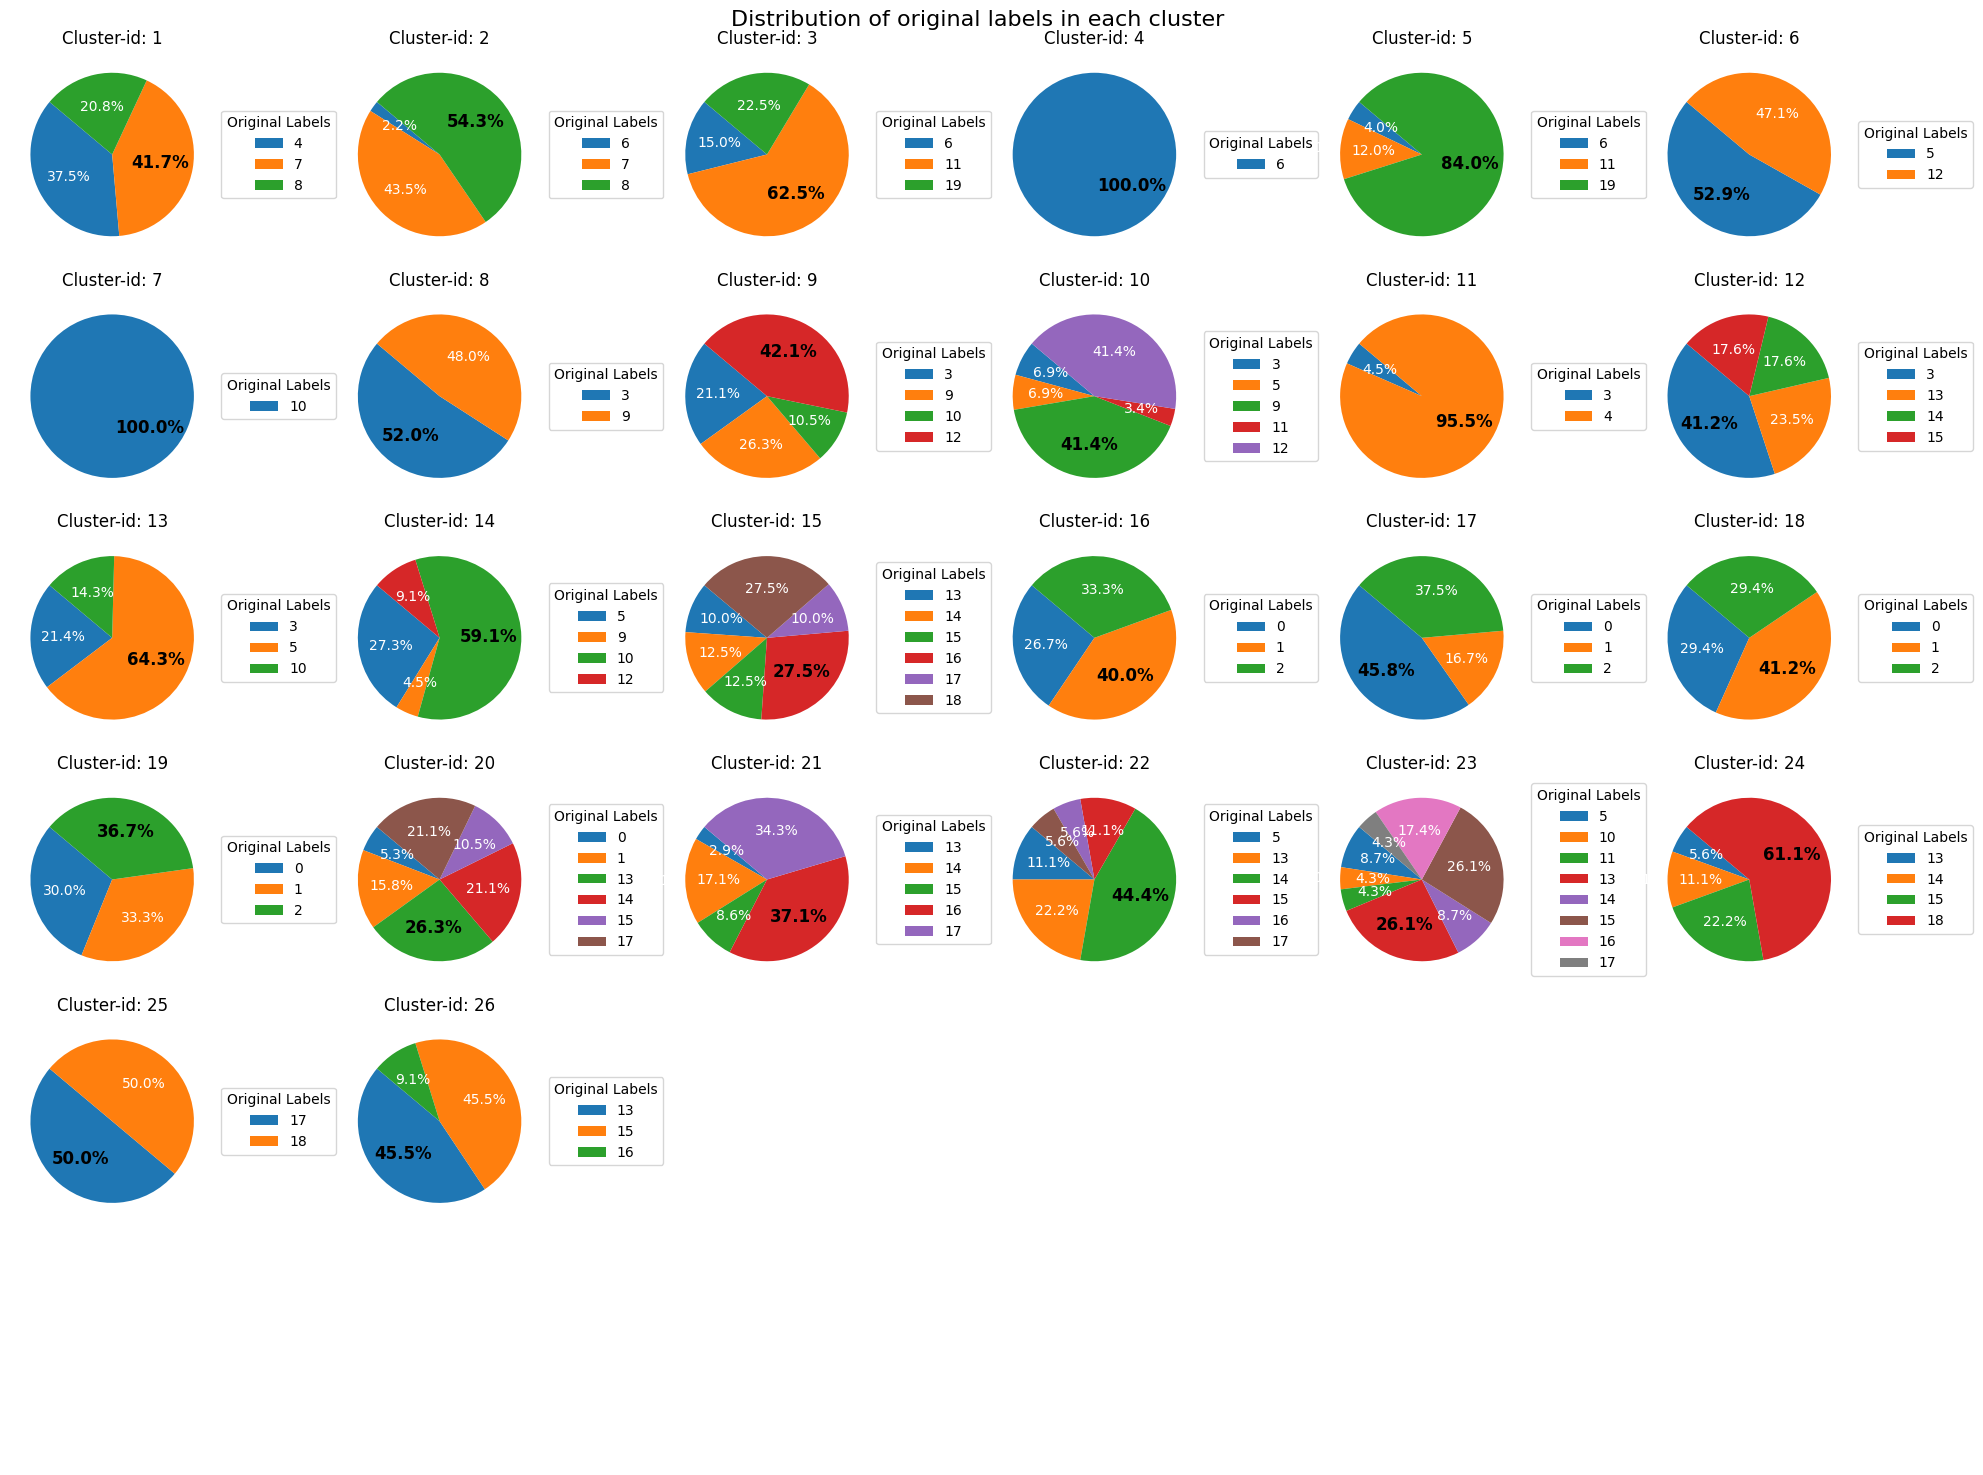

In [93]:
model = HierarchicalModel(best_cluster_num, 'ward', 'euclidean')
euclidean_cluster_labels = model.fit_predict(X_umap)
print("Cluster labels for each image:", Counter(euclidean_cluster_labels))

plt.bar(range(best_cluster_num +1), np.bincount(euclidean_cluster_labels))
plt.xlabel('Cluster')
plt.ylabel('Number of images')
plt.title('Number of images per cluster')
plt.xticks(range(best_cluster_num+1))
plt.show()

plot_cluster_distribution_with_majority(original_labels, euclidean_cluster_labels)

Result for metric = Cityblock and linkage = Average

Cluster labels for each image: Counter({16: 48, 2: 44, 4: 43, 7: 39, 24: 38, 14: 33, 21: 29, 8: 28, 1: 26, 26: 24, 13: 23, 5: 22, 6: 22, 17: 20, 20: 18, 19: 18, 23: 18, 15: 17, 22: 17, 25: 16, 11: 16, 12: 12, 10: 12, 9: 11, 18: 4, 3: 2})


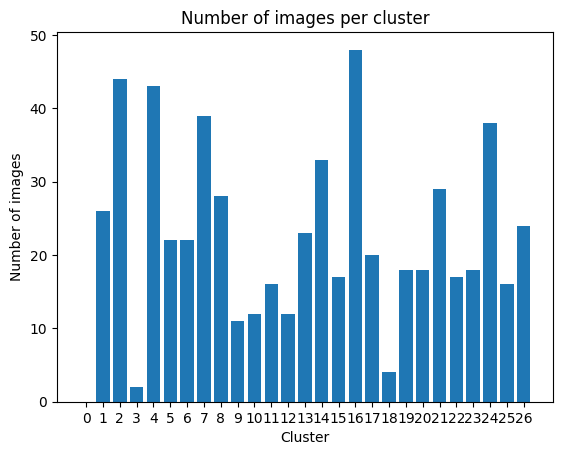


Clusters with majority percentage > 50% (sorted by cluster ID):
Cluster 2: Majority label 8 with 23 images (52.3%)
Cluster 3: Majority label 3 with 2 images (100.0%)
Cluster 4: Majority label 11 with 27 images (62.8%)
Cluster 5: Majority label 6 with 22 images (100.0%)
Cluster 6: Majority label 19 with 20 images (90.9%)
Cluster 12: Majority label 10 with 12 images (100.0%)
Cluster 13: Majority label 9 with 12 images (52.2%)
Cluster 15: Majority label 5 with 9 images (52.9%)
Cluster 18: Majority label 4 with 4 images (100.0%)
Cluster 19: Majority label 4 with 17 images (94.4%)
Cluster 22: Majority label 18 with 11 images (64.7%)
Cluster 23: Majority label 17 with 12 images (66.7%)

Clusters with majority percentage <= 50% (sorted by true label):
Cluster 7: Majority label 0 with 15 images (38.5%)
Cluster 20: Majority label 0 with 8 images (44.4%)
Cluster 21: Majority label 1 with 13 images (44.8%)
Cluster 17: Majority label 3 with 10 images (50.0%)
Cluster 14: Majority label 5 with 15 i

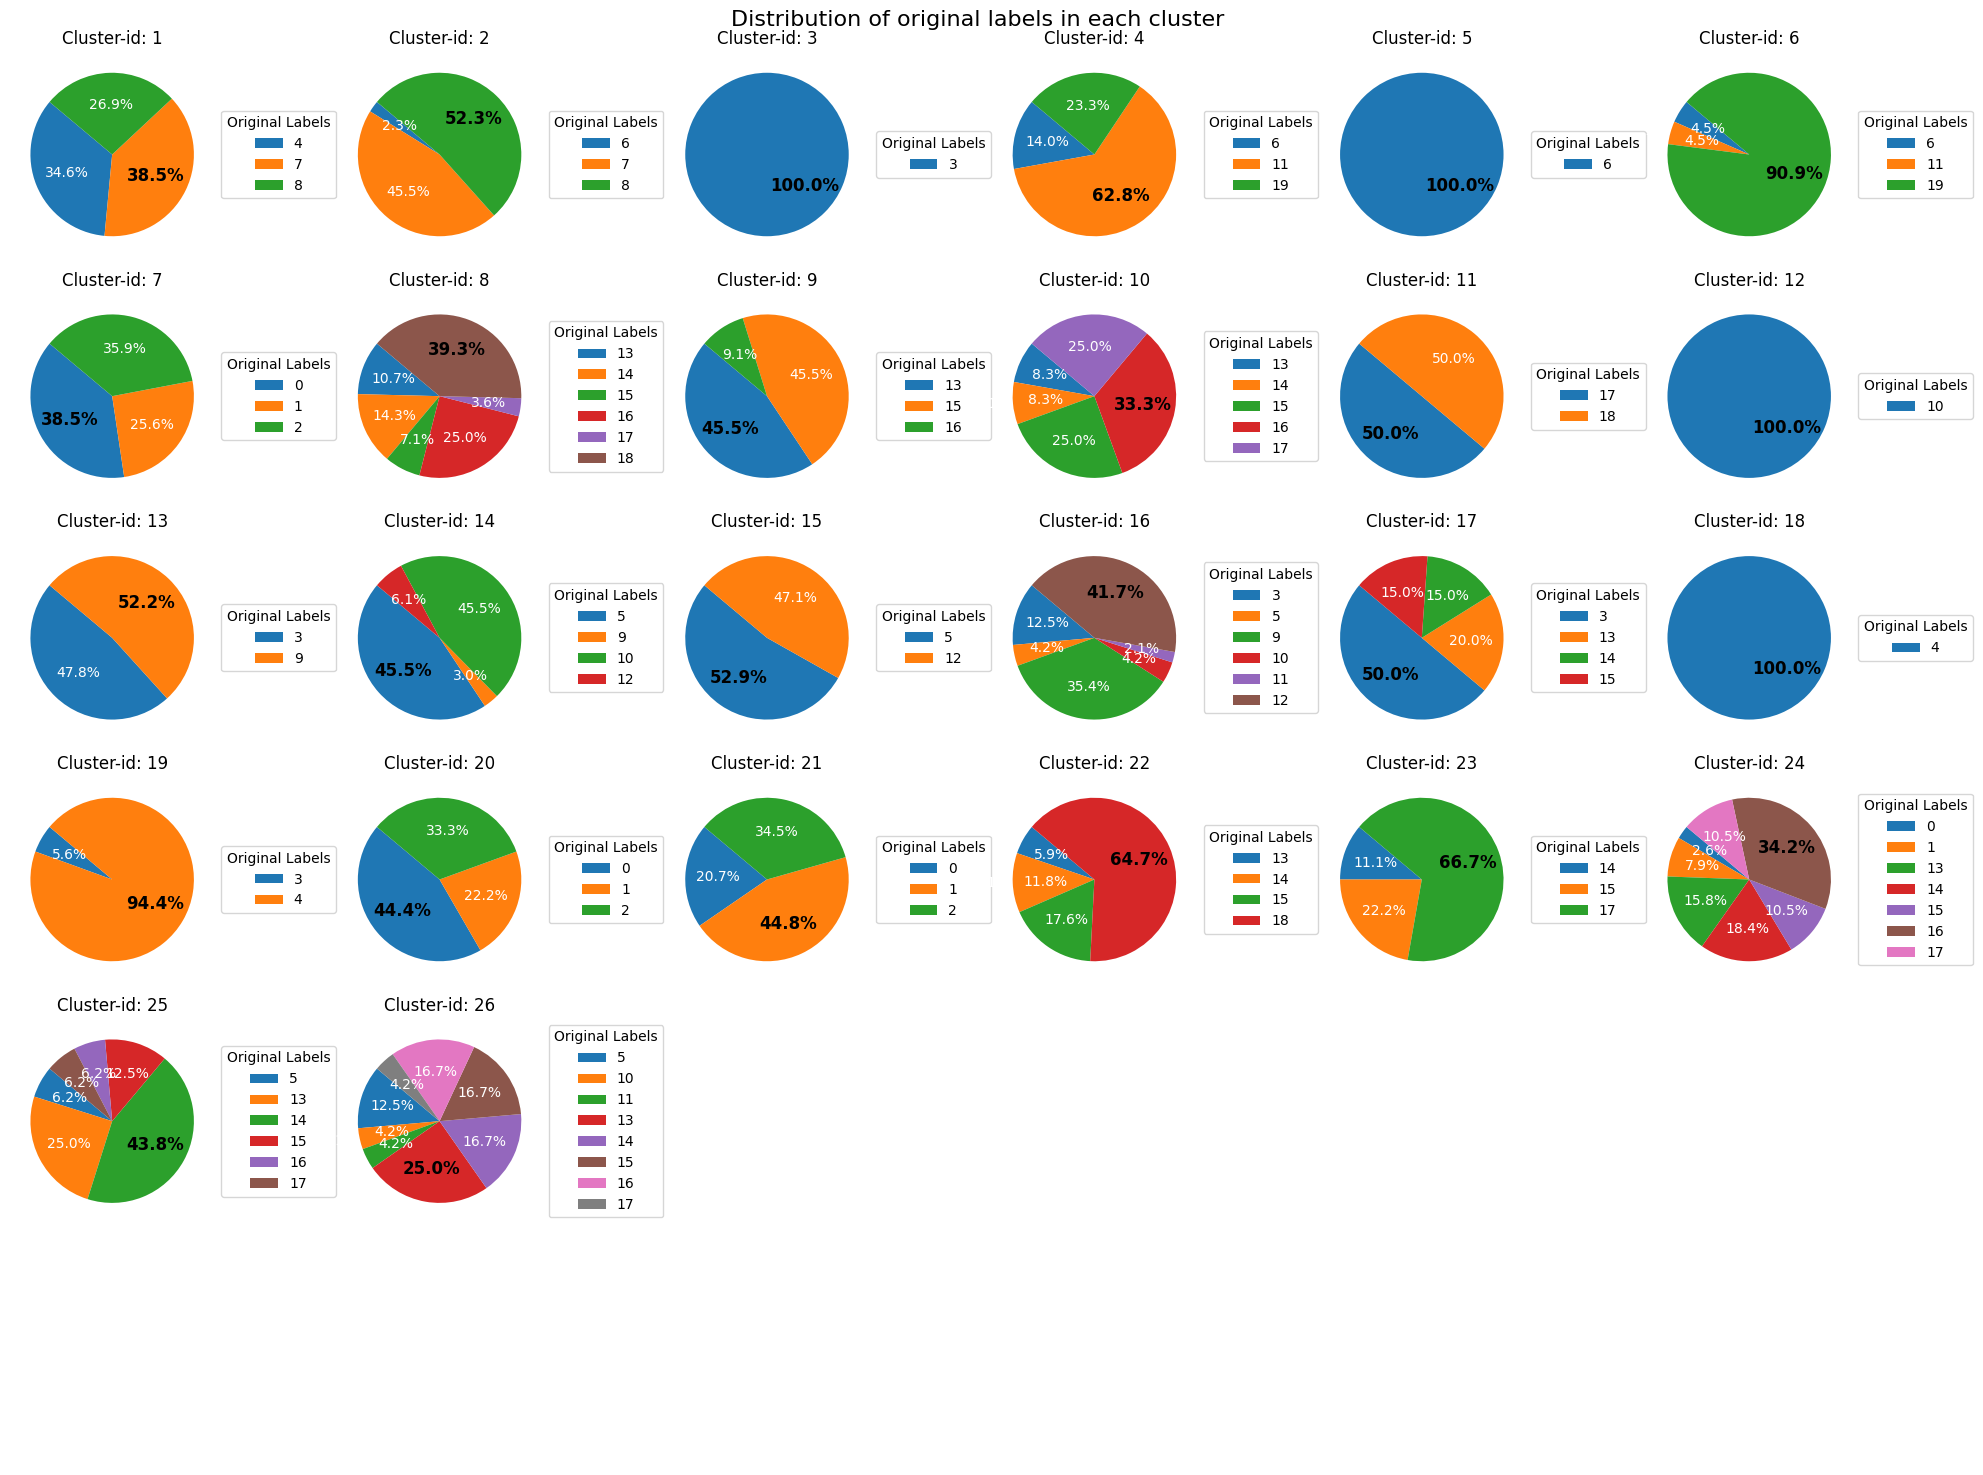

In [94]:
model = HierarchicalModel(best_cluster_num, 'average', 'cityblock')
cityblock_cluster_labels = model.fit_predict(X_umap)
print("Cluster labels for each image:", Counter(cityblock_cluster_labels))

plt.bar(range(best_cluster_num +1), np.bincount(cityblock_cluster_labels))
plt.xlabel('Cluster')
plt.ylabel('Number of images')
plt.title('Number of images per cluster')
plt.xticks(range(best_cluster_num+1))
plt.show()

plot_cluster_distribution_with_majority(original_labels, cityblock_cluster_labels)

Result for metric = Minkowski and linkage = Centroid

Cluster labels for each image: Counter({9: 57, 17: 49, 26: 46, 23: 43, 1: 39, 7: 30, 3: 28, 24: 24, 16: 23, 21: 22, 25: 22, 22: 22, 15: 21, 11: 20, 13: 18, 6: 17, 19: 17, 10: 17, 8: 17, 4: 16, 20: 12, 2: 12, 5: 11, 14: 10, 12: 4, 18: 3})


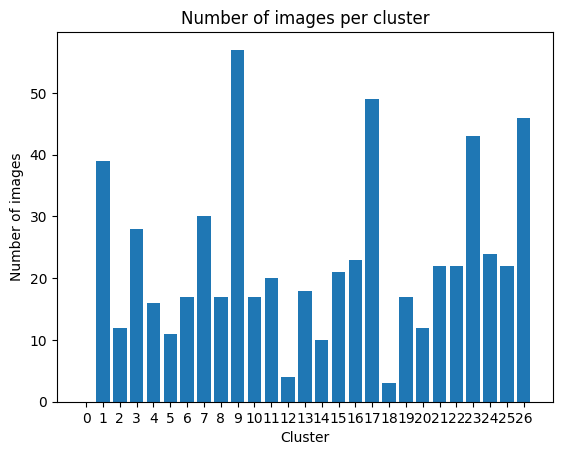


Clusters with majority percentage > 50% (sorted by cluster ID):
Cluster 8: Majority label 18 with 11 images (64.7%)
Cluster 12: Majority label 4 with 4 images (100.0%)
Cluster 13: Majority label 4 with 17 images (94.4%)
Cluster 16: Majority label 10 with 13 images (56.5%)
Cluster 18: Majority label 3 with 3 images (100.0%)
Cluster 19: Majority label 5 with 9 images (52.9%)
Cluster 20: Majority label 10 with 12 images (100.0%)
Cluster 21: Majority label 9 with 12 images (54.5%)
Cluster 22: Majority label 19 with 20 images (90.9%)
Cluster 23: Majority label 11 with 27 images (62.8%)
Cluster 25: Majority label 6 with 22 images (100.0%)
Cluster 26: Majority label 8 with 25 images (54.3%)

Clusters with majority percentage <= 50% (sorted by true label):
Cluster 1: Majority label 0 with 15 images (38.5%)
Cluster 6: Majority label 0 with 8 images (47.1%)
Cluster 7: Majority label 1 with 14 images (46.7%)
Cluster 15: Majority label 3 with 10 images (47.6%)
Cluster 24: Majority label 7 with 10

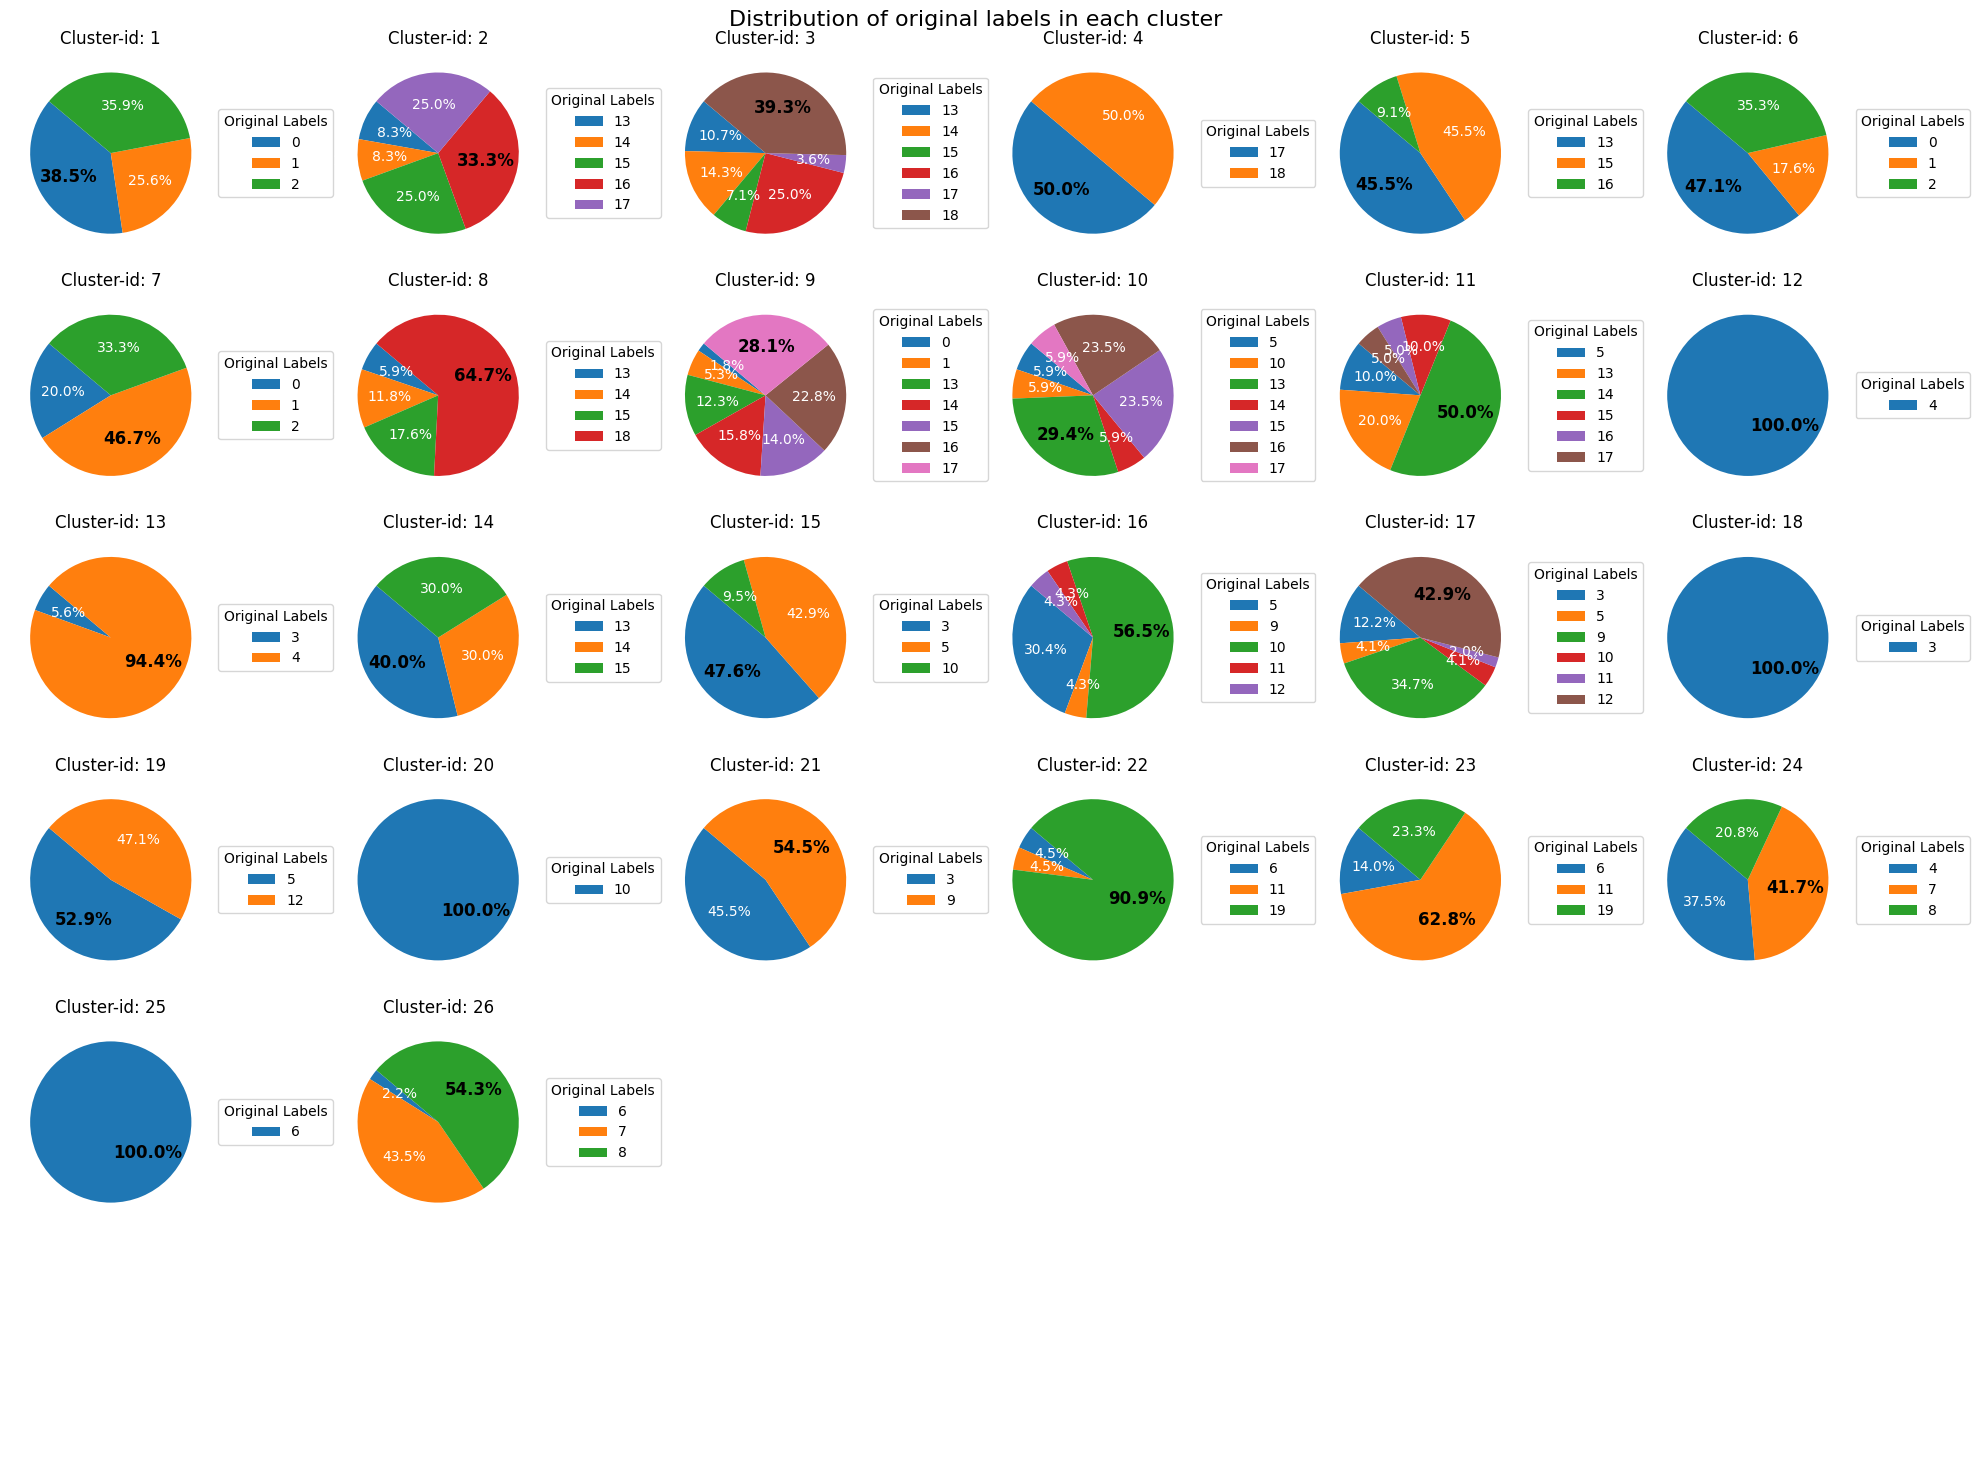

In [95]:
model = HierarchicalModel(best_cluster_num, 'centroid', 'minkowski')
minkowski_cluster_labels = model.fit_predict(X_umap)
print("Cluster labels for each image:", Counter(minkowski_cluster_labels))

plt.bar(range(best_cluster_num +1), np.bincount(minkowski_cluster_labels))
plt.xlabel('Cluster')
plt.ylabel('Number of images')
plt.title('Number of images per cluster')
plt.xticks(range(best_cluster_num+1))
plt.show()

plot_cluster_distribution_with_majority(original_labels, minkowski_cluster_labels)

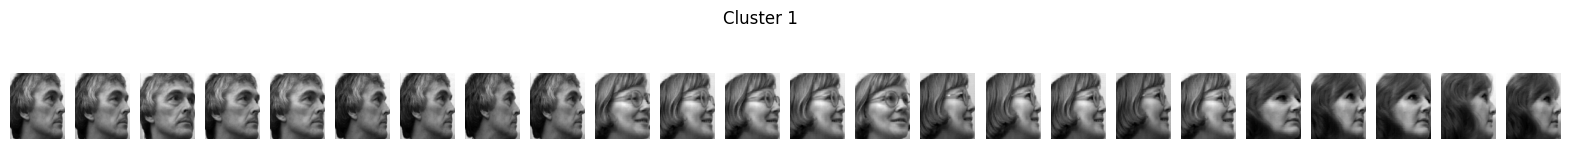

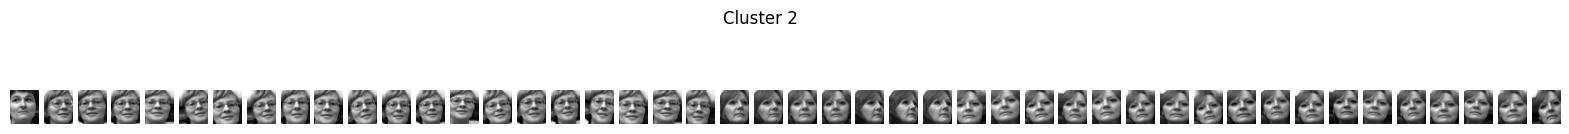

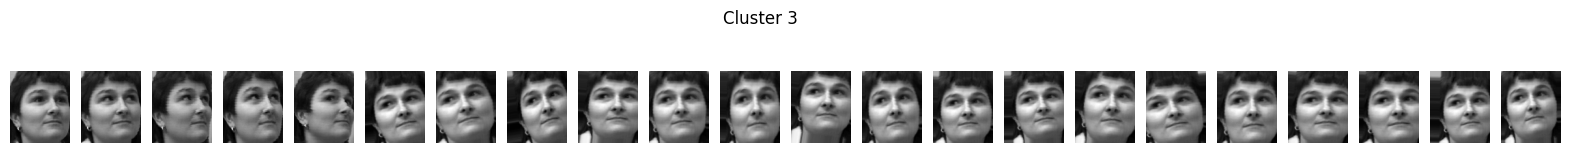

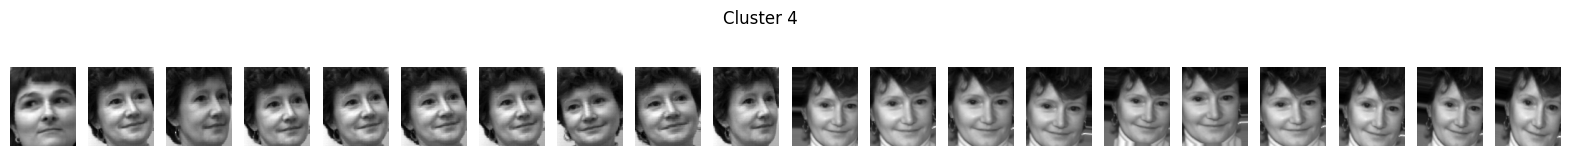

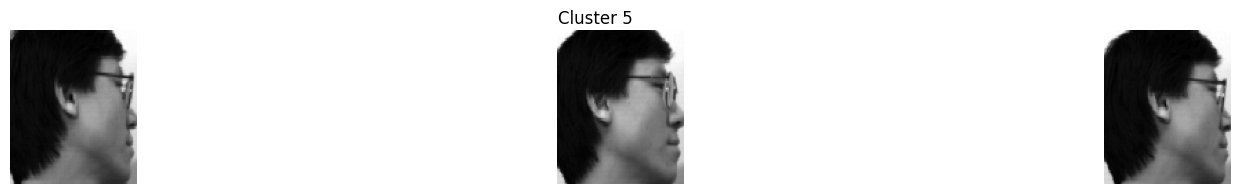

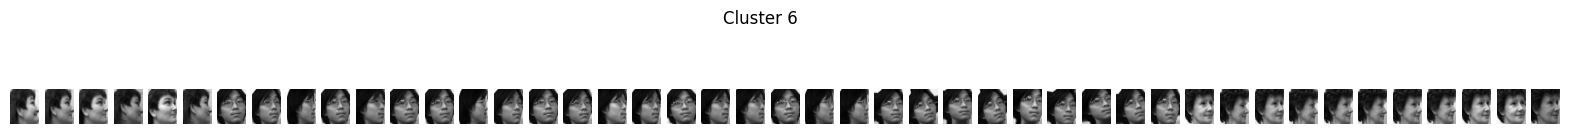

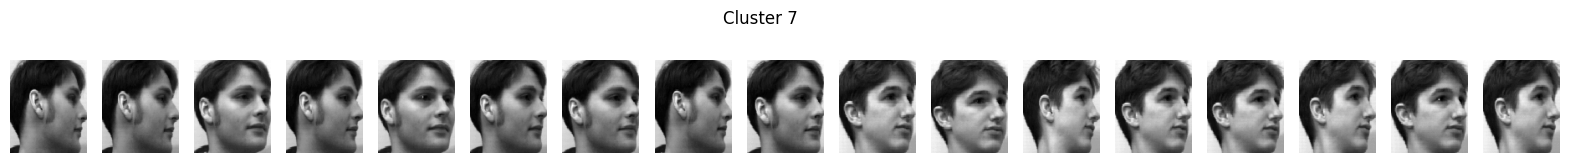

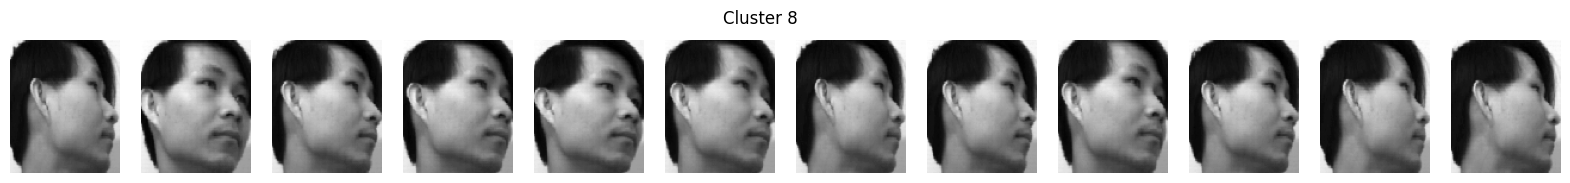

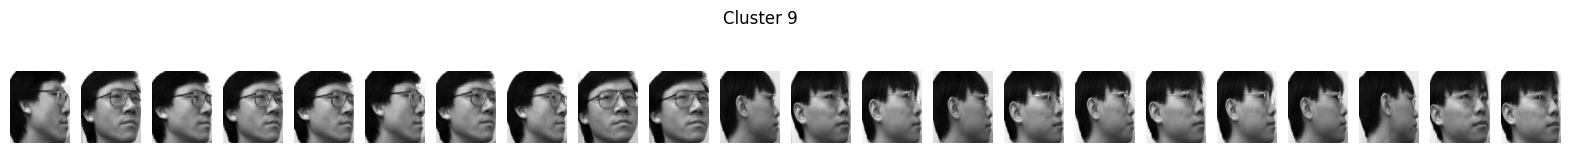

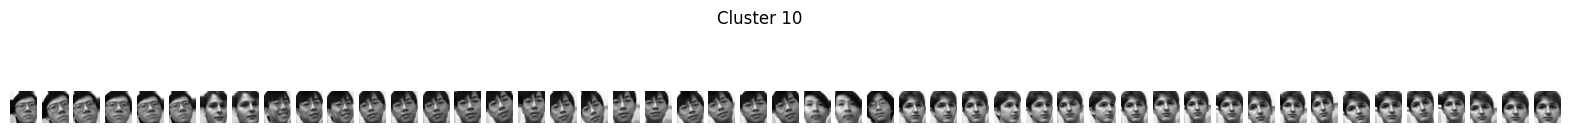

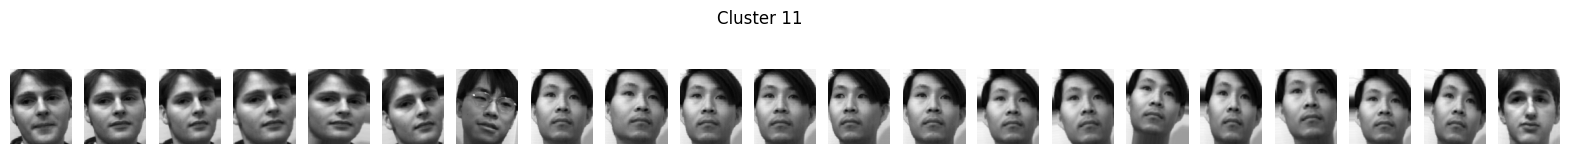

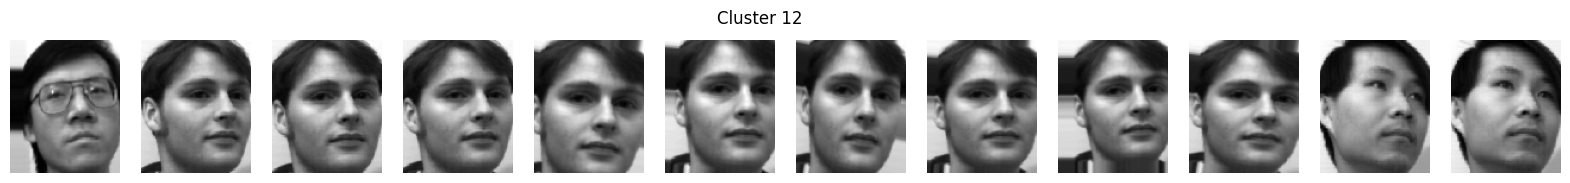

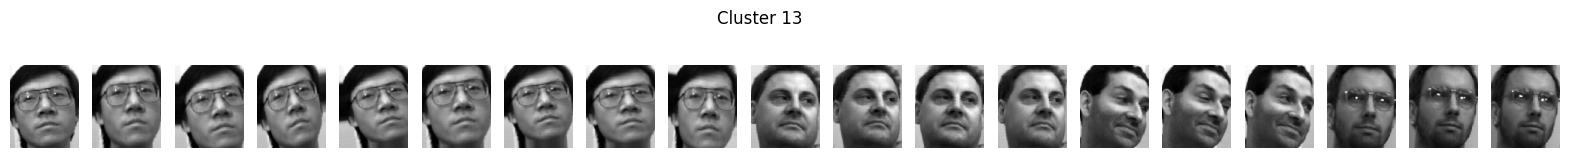

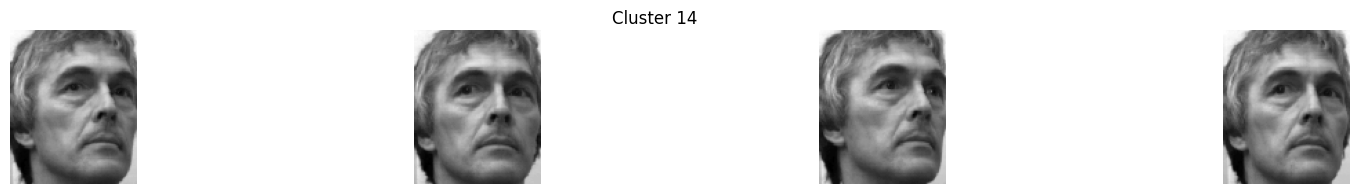

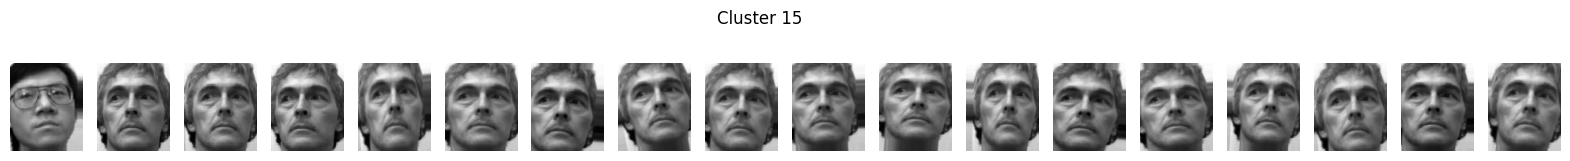

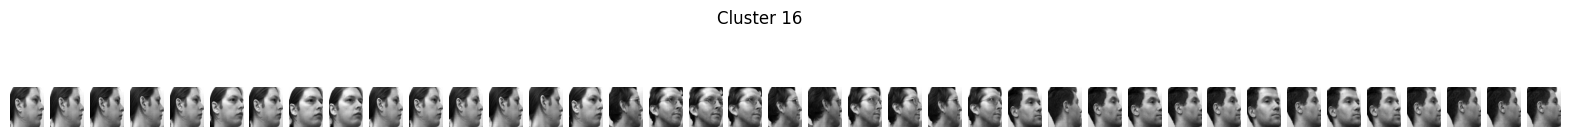

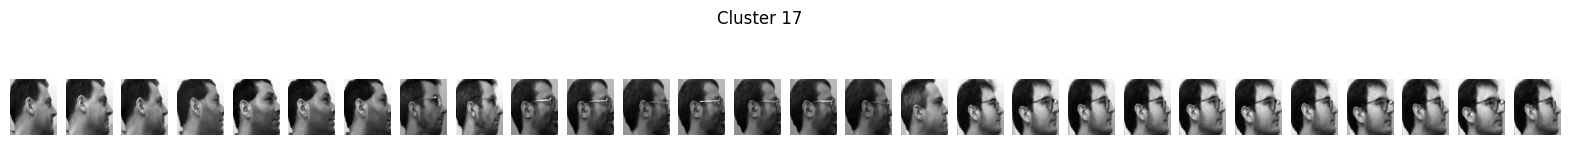

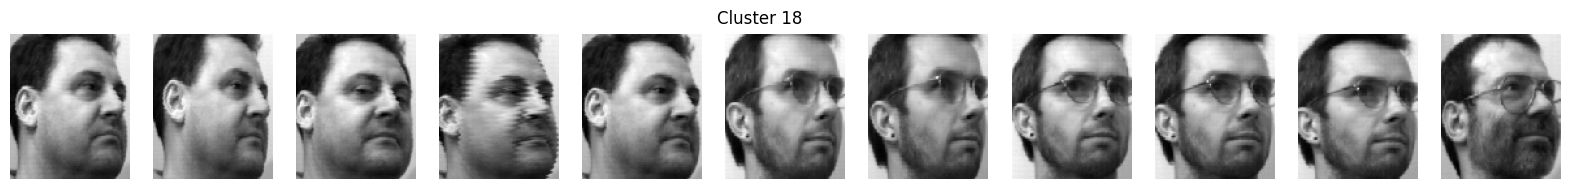

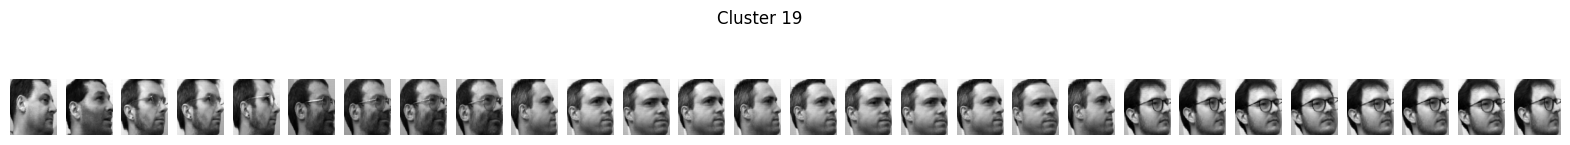

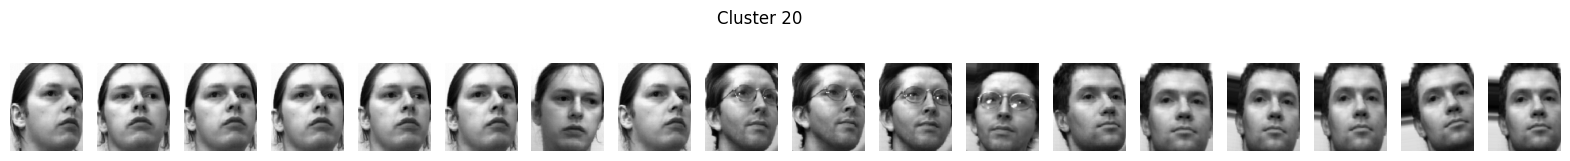

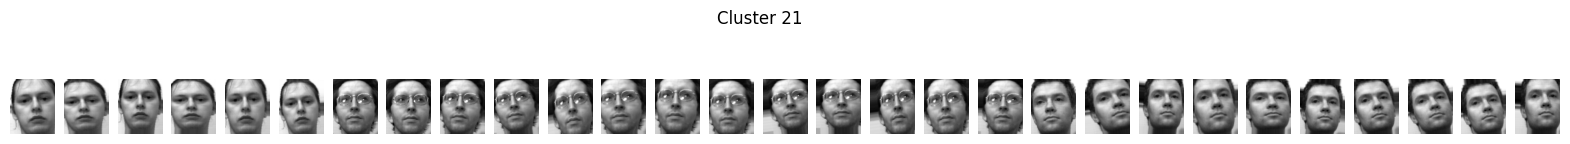

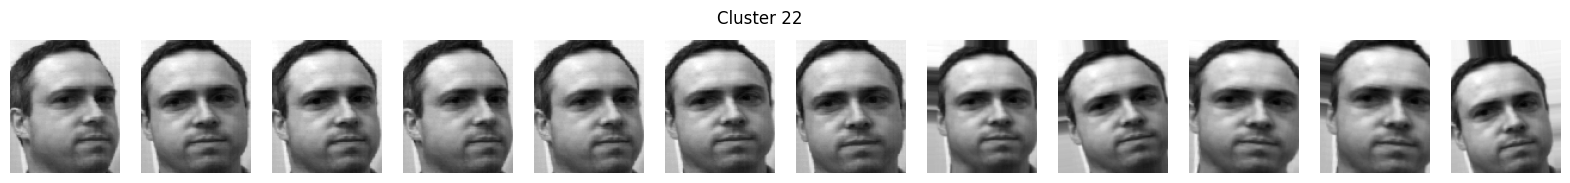

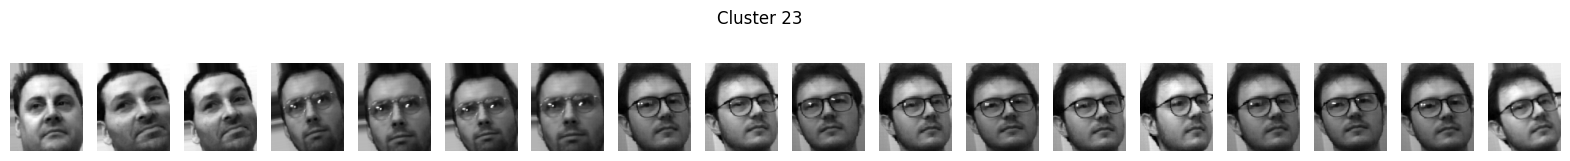

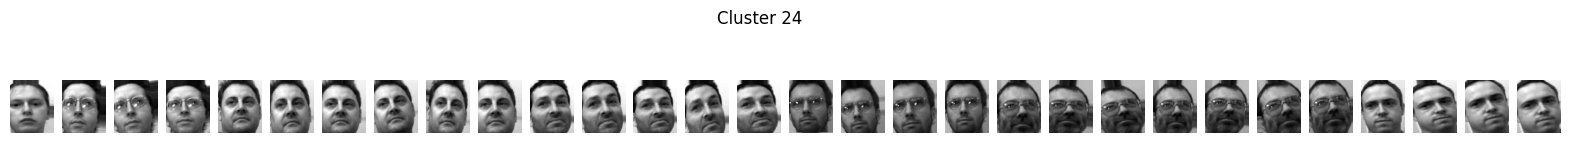

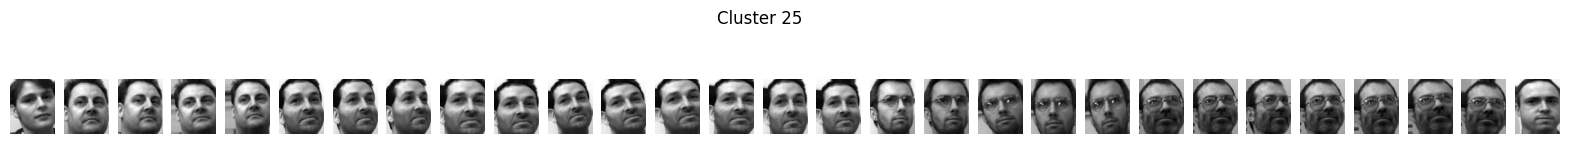

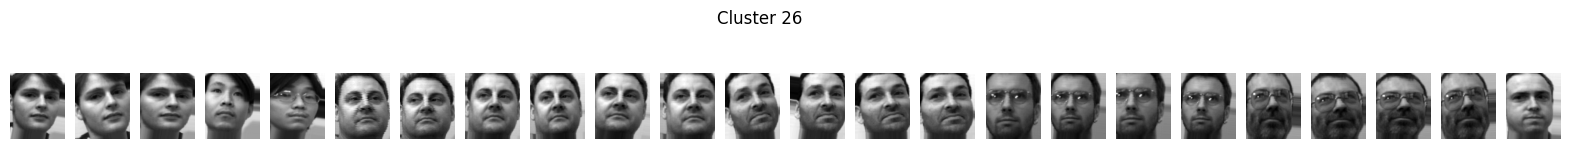

In [96]:
plot_result(cosine_cluster_labels, best_cluster_num)

In [97]:
best_cluster_labels = cosine_cluster_labels

In [98]:
umist_cropped_training = pd.read_csv("data/umist_cropped.csv")

umist_cropped_training['cluster_id'] = best_cluster_labels

umist_cropped_training.to_csv("data/umist_cropped_with_cluster_id_training.csv", index=False)

In [99]:
umist_cropped_val = pd.read_csv("data/validation_data/umist_val.csv")

X_val = umist_cropped_val.to_numpy()

In [100]:
X_val_scaled = scaler.transform(X_val)
X_val_pca = pca.transform(X_val_scaled)
X_val_umap = umap_reducer.transform(X_val_pca)

In [101]:
best_model = HierarchicalModel(best_cluster_num, 'centroid', 'cosine')
cluster_labels_train = best_model.fit_predict(X_umap)

In [102]:
silhouette_score(X_umap, cluster_labels_train)

0.4995931

In [103]:
cluster_labels_val = best_model.predict(X_val_umap)

In [104]:
silhouette_score(X_val_umap, cluster_labels_val)

0.4120807

In [105]:
umist_cropped_val['cluster_id'] = cluster_labels_val

umist_cropped_val.to_csv("data/validation_data/umist_cropped_with_cluster_id_val.csv", index=False)